**Overview**


In this assignment, you will work on the "blogs_categories.csv" dataset, which contains blog posts categorized into various themes. Your task will be to build a text classification model using the Naive Bayes algorithm to categorize the blog posts accurately. Furthermore, you will perform sentiment analysis to understand the general sentiment (positive, negative, neutral) expressed in these posts. This assignment will enhance your understanding of text classification, sentiment analysis, and the practical application of the Naive Bayes algorithm in Natural Language Processing (NLP).

The provided dataset, "blogs_categories.csv", consists of blog posts along with their associated categories. Each row represents a blog post with the following columns:

• Text: The content of the blog post. Column name: Data

• Category: The category to which the blog post belongs. Column name: Labels

In [1]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 300
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from wordcloud import WordCloud
from textblob import TextBlob

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df0 = pd.read_csv('blogs.csv')
df0.head()

Data       Labels
0  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...  alt.atheism
1  Newsgroups: alt.atheism\nPath: cantaloupe.srv....  alt.atheism
2  Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...  alt.atheism
3  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...  alt.atheism
4  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...  alt.atheism

In [3]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    2000 non-null   object
 1   Labels  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [4]:
print('No. of Duplicate Records =',df0.duplicated().sum())
df=df0.copy()


No. of Duplicate Records = 0


In [5]:
df.describe(include=object)

Data       Labels
count                                                2000         2000
unique                                               2000           20
top     Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...  alt.atheism
freq                                                    1          100

In [6]:
df['Labels'].value_counts()

Labels
alt.atheism                 100
comp.graphics               100
talk.politics.misc          100
talk.politics.mideast       100
talk.politics.guns          100
soc.religion.christian      100
sci.space                   100
sci.med                     100
sci.electronics             100
sci.crypt                   100
rec.sport.hockey            100
rec.sport.baseball          100
rec.motorcycles             100
rec.autos                   100
misc.forsale                100
comp.windows.x              100
comp.sys.mac.hardware       100
comp.sys.ibm.pc.hardware    100
comp.os.ms-windows.misc     100
talk.religion.misc          100
Name: count, dtype: int64

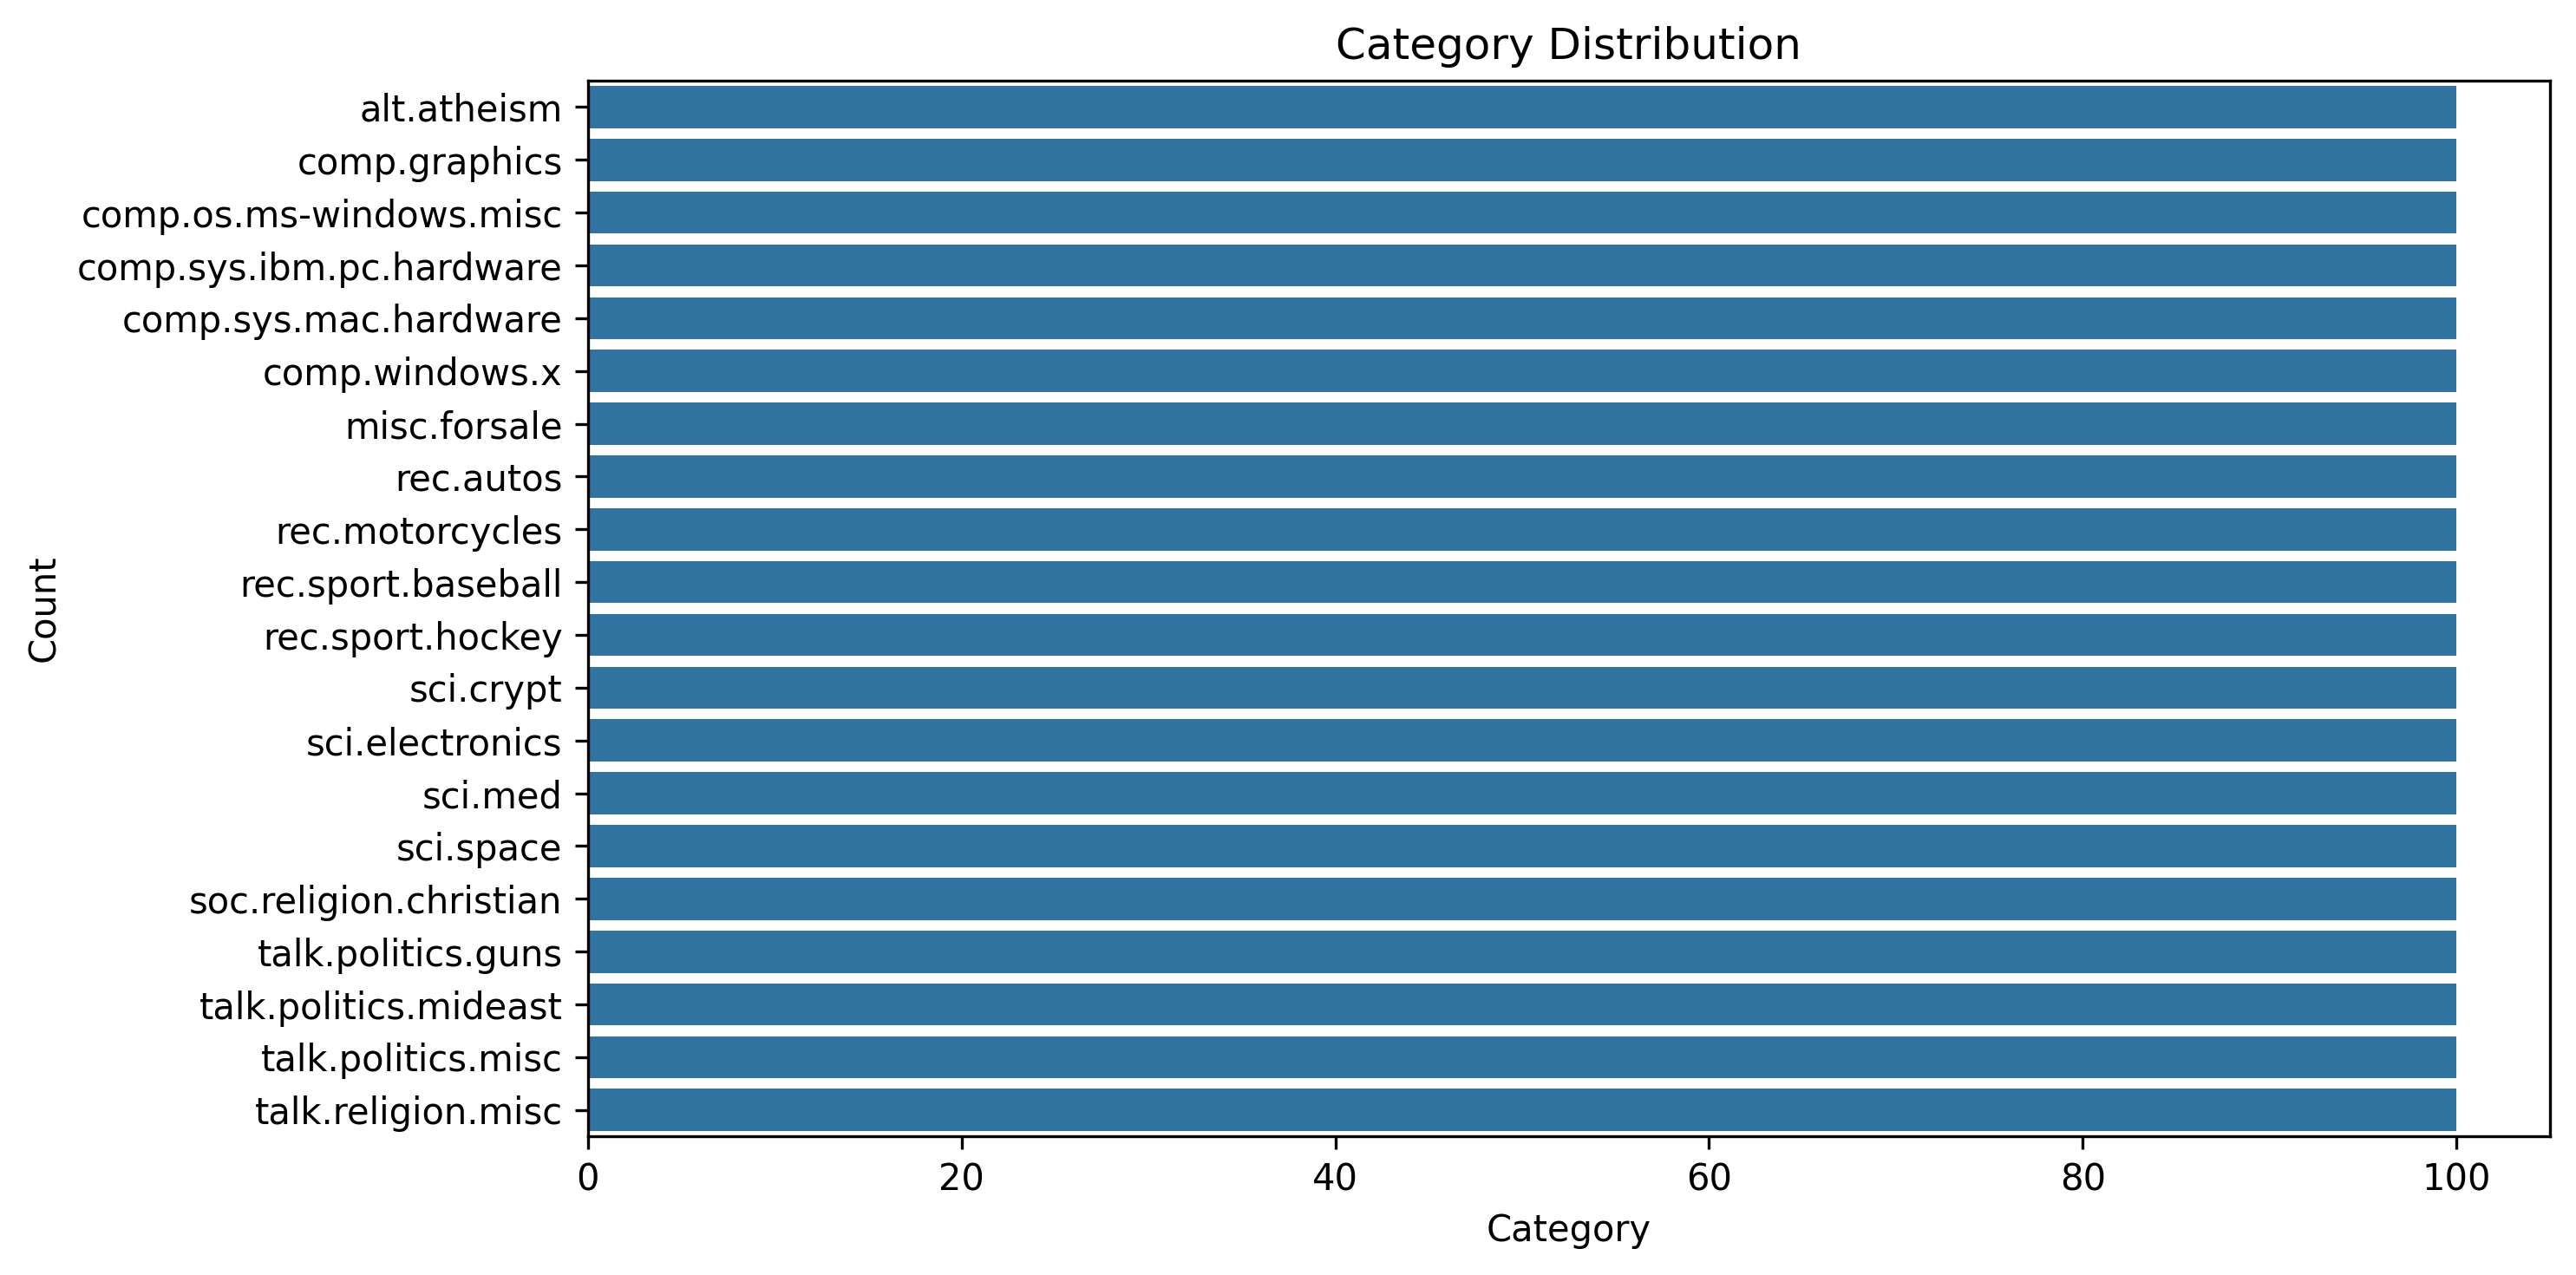

In [7]:
#count plot
sns.countplot(y = df['Labels'])
plt.title('Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.tight_layout()
#plt.xticks(rotation=90)
plt.show()

In [8]:
new_labels = {}
for label in df['Labels'].unique():
    new_labels[label] = label.replace('.','_')

df['Labels'] = df['Labels'].replace(new_labels)
df.head()

Data       Labels
0  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...  alt_atheism
1  Newsgroups: alt.atheism\nPath: cantaloupe.srv....  alt_atheism
2  Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...  alt_atheism
3  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...  alt_atheism
4  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...  alt_atheism

In [9]:
#add numerical labels
num_labels = {}
count = 1
for label in df['Labels'].unique():
    num_labels[label] = count
    count += 1

df['Num_labels'] = df['Labels'].map(num_labels)
df.head()

Data       Labels  Num_labels
0  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...  alt_atheism           1
1  Newsgroups: alt.atheism\nPath: cantaloupe.srv....  alt_atheism           1
2  Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...  alt_atheism           1
3  Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...  alt_atheism           1
4  Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...  alt_atheism           1

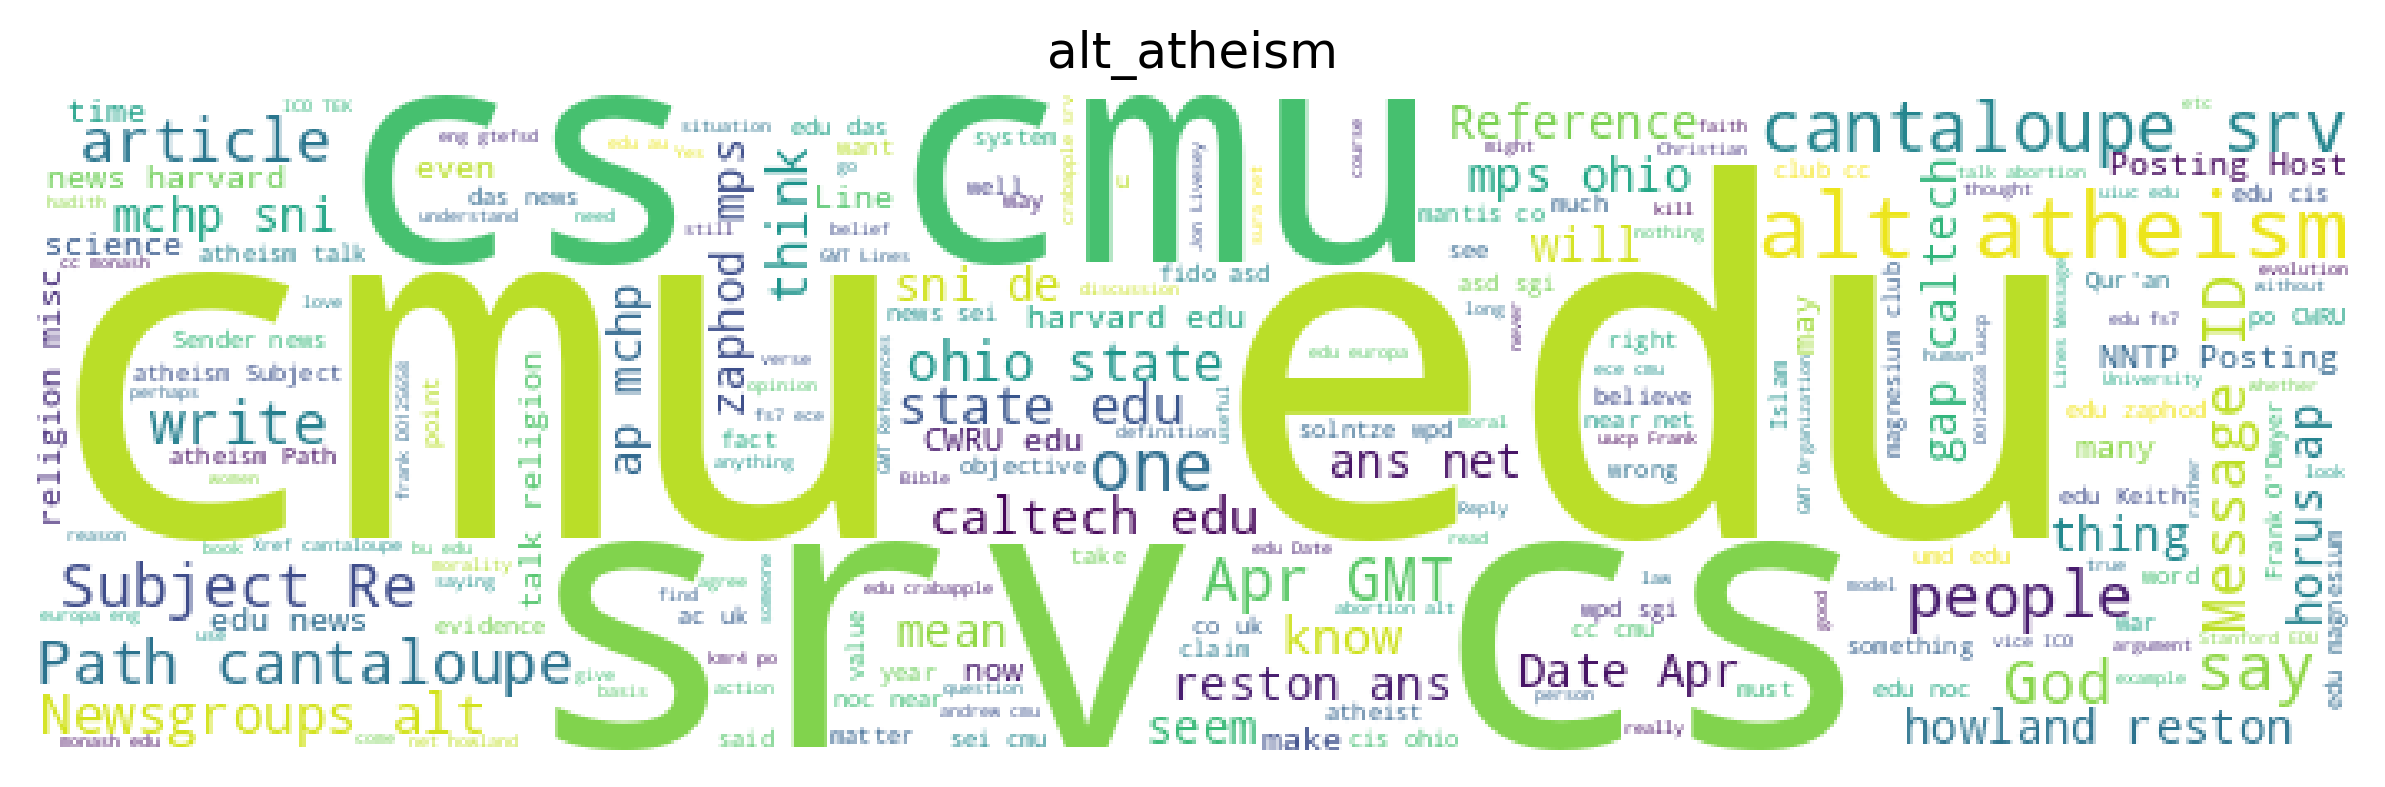


-------------------------------------------------------------------------------------------------------------------------------------------------------------------



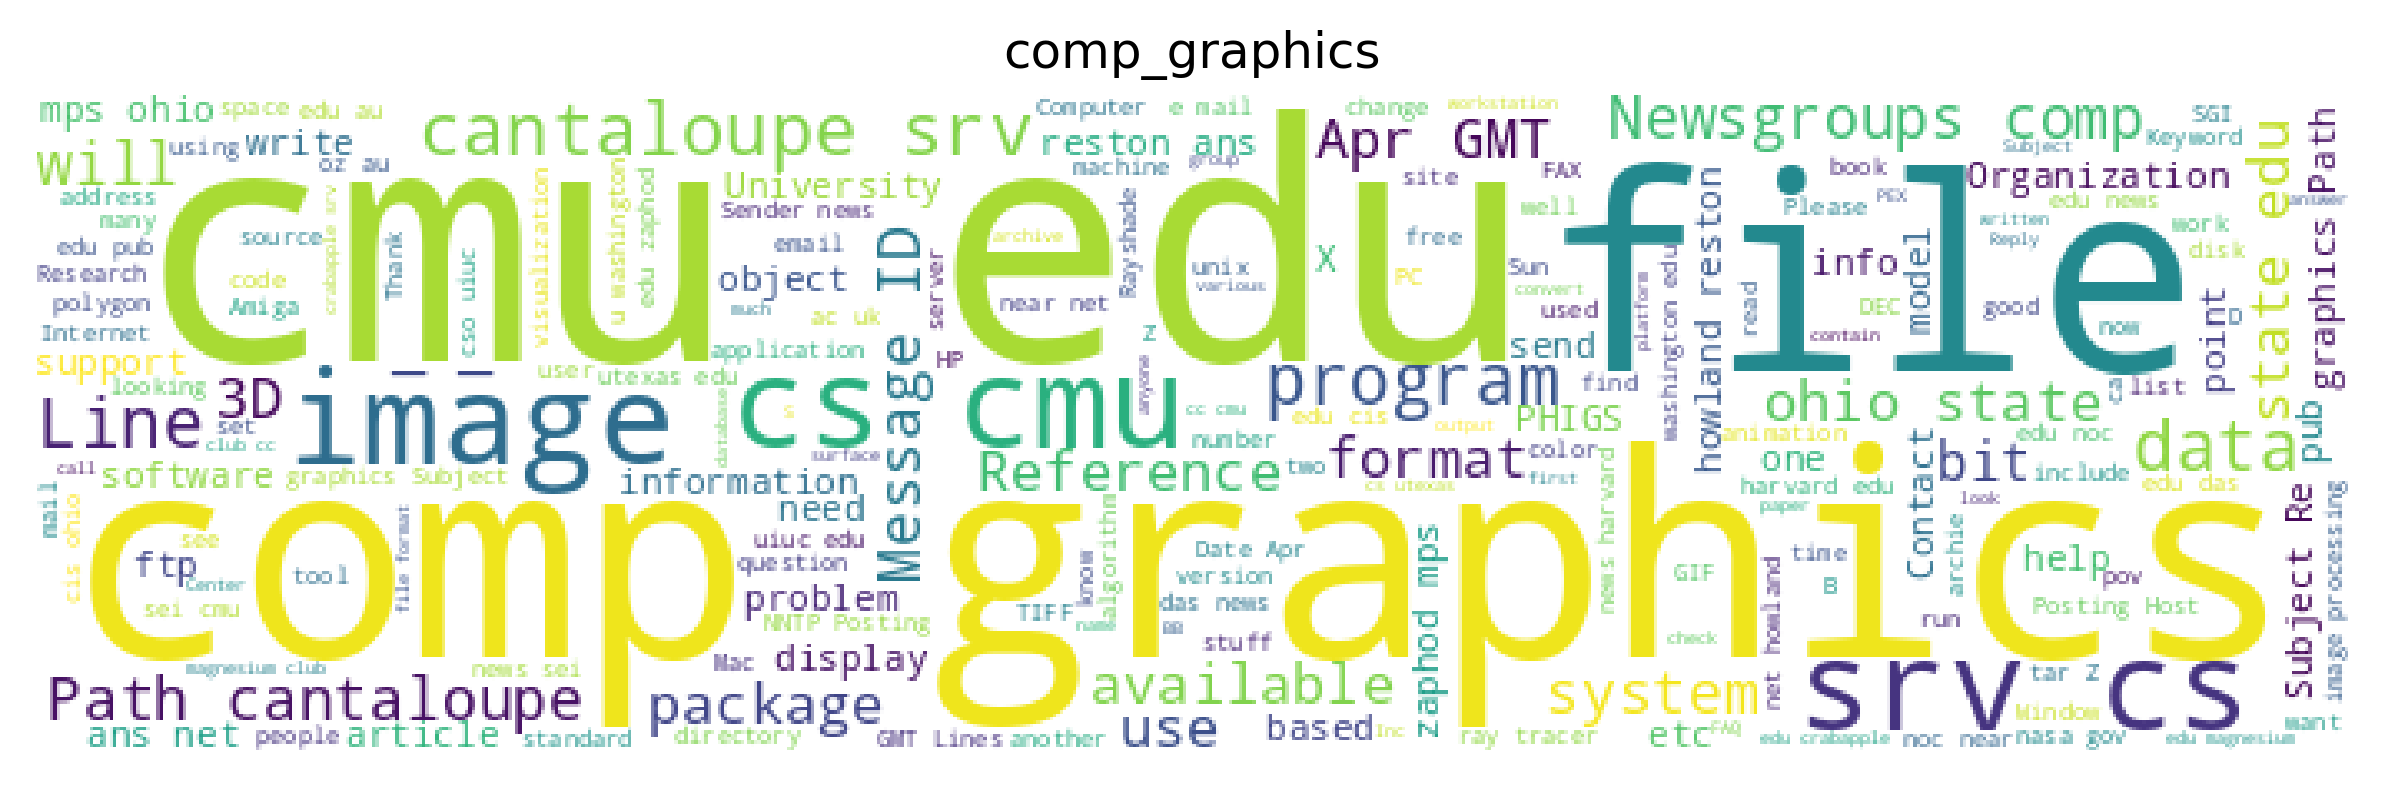


-------------------------------------------------------------------------------------------------------------------------------------------------------------------



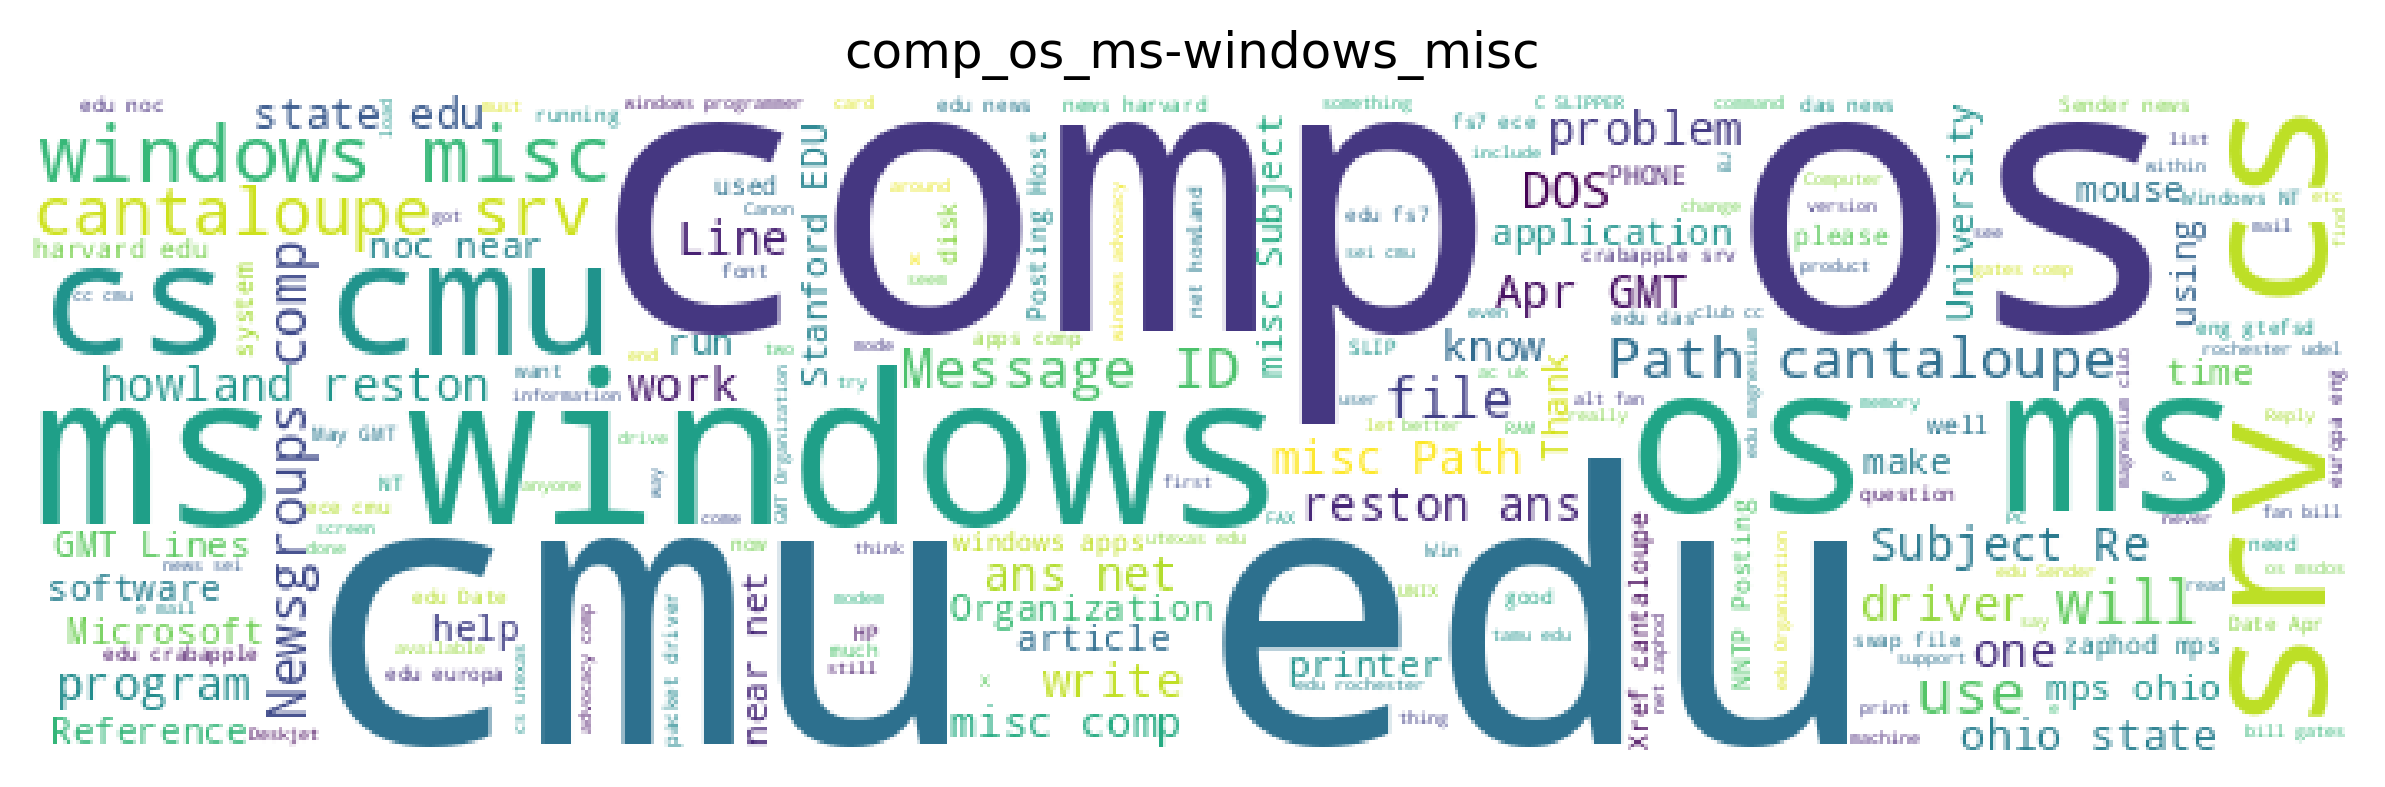


-------------------------------------------------------------------------------------------------------------------------------------------------------------------



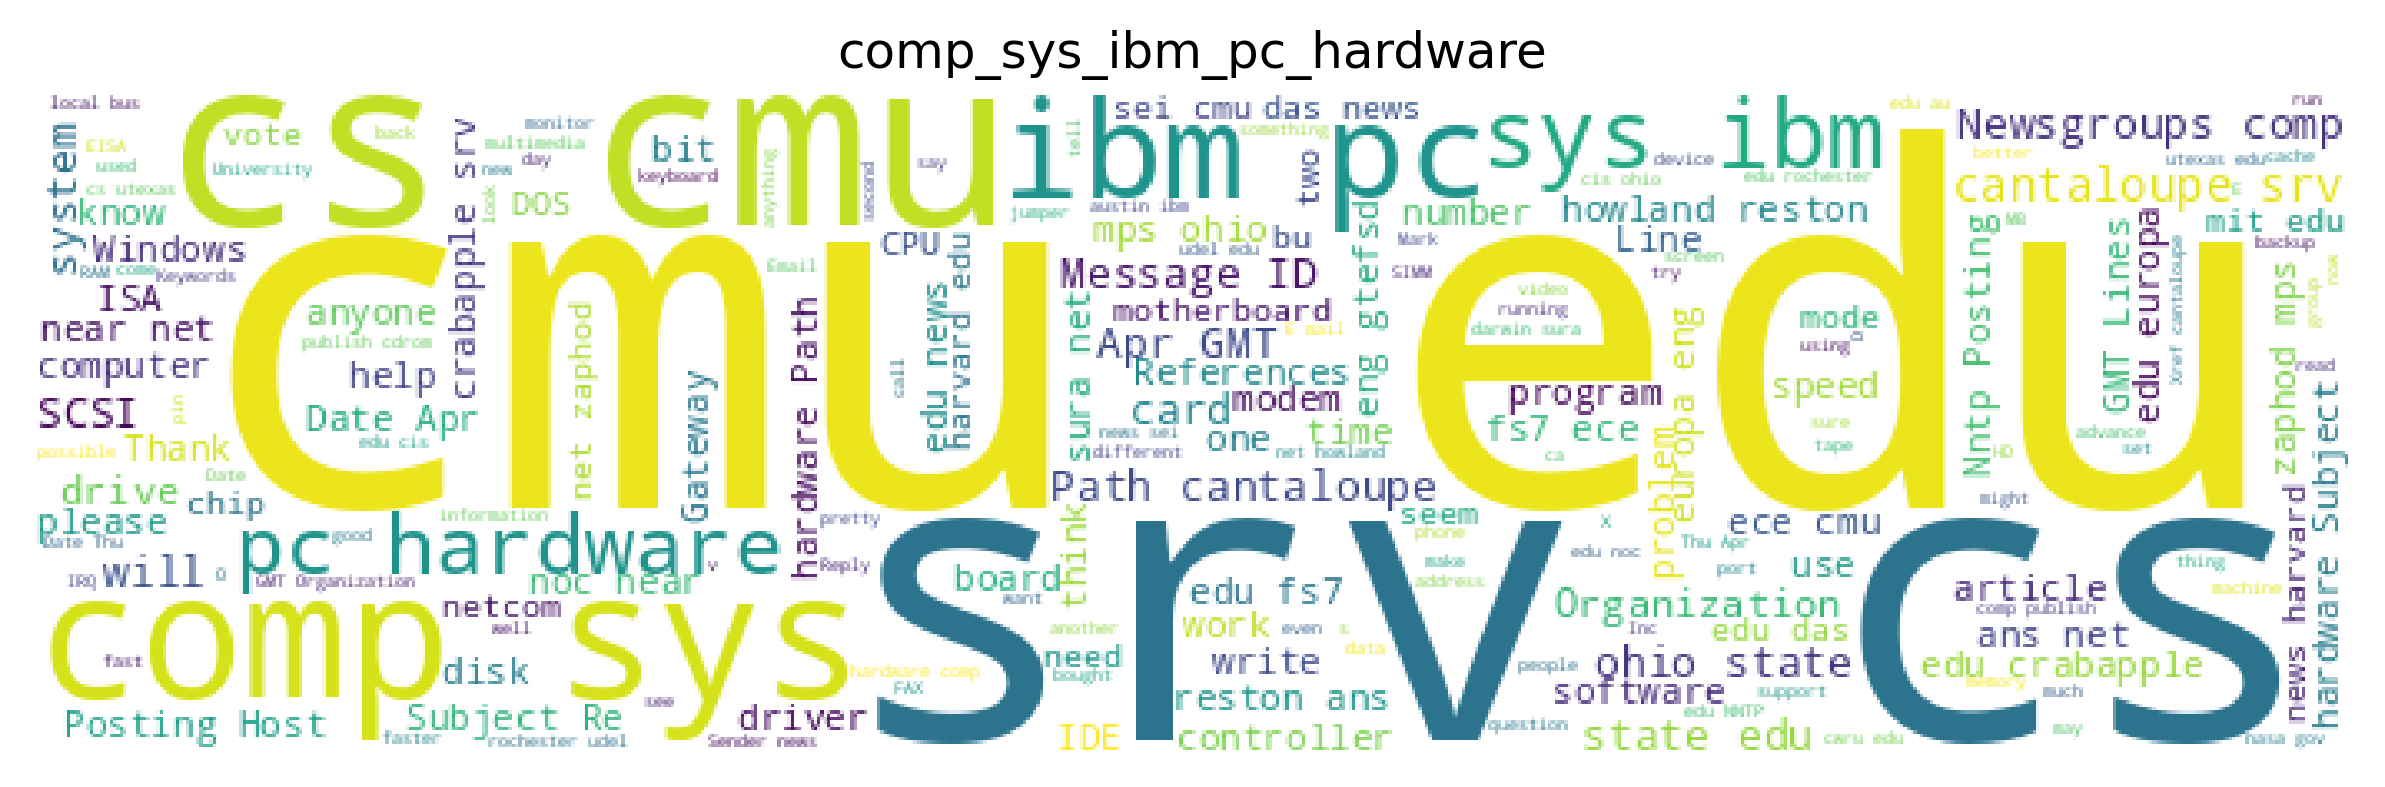


-------------------------------------------------------------------------------------------------------------------------------------------------------------------



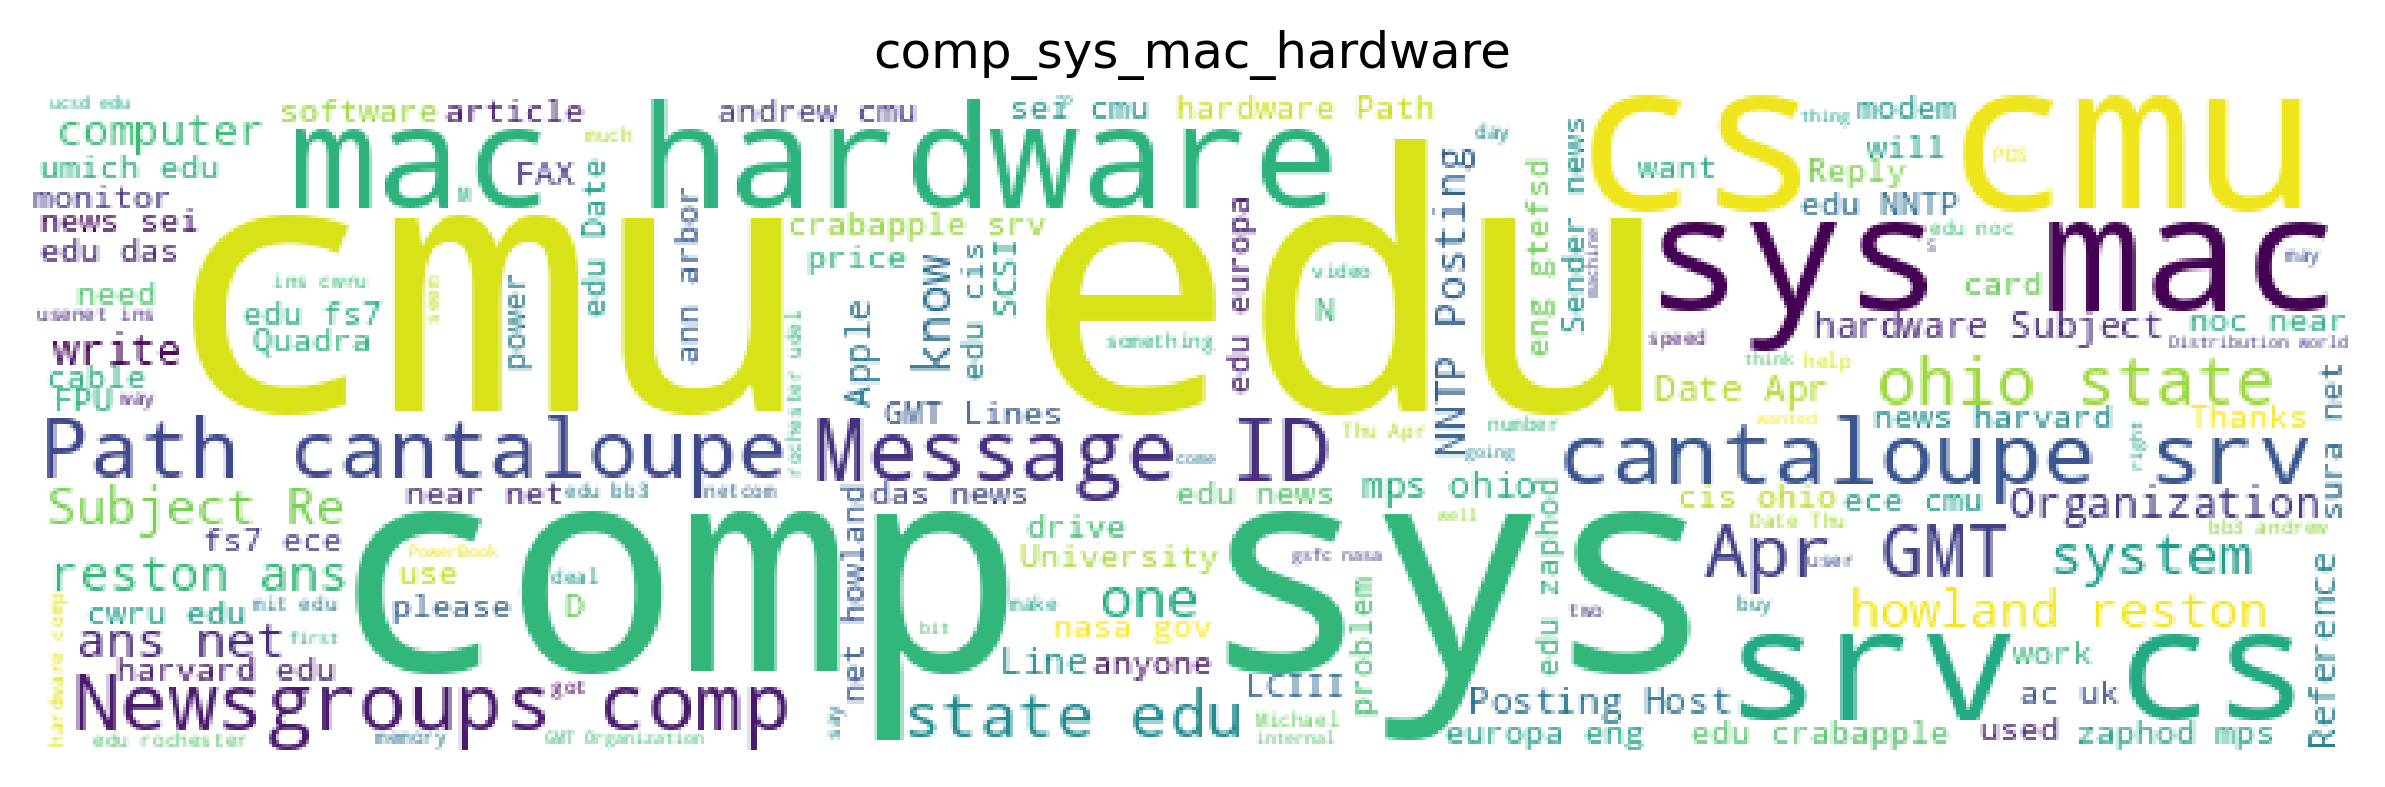


-------------------------------------------------------------------------------------------------------------------------------------------------------------------



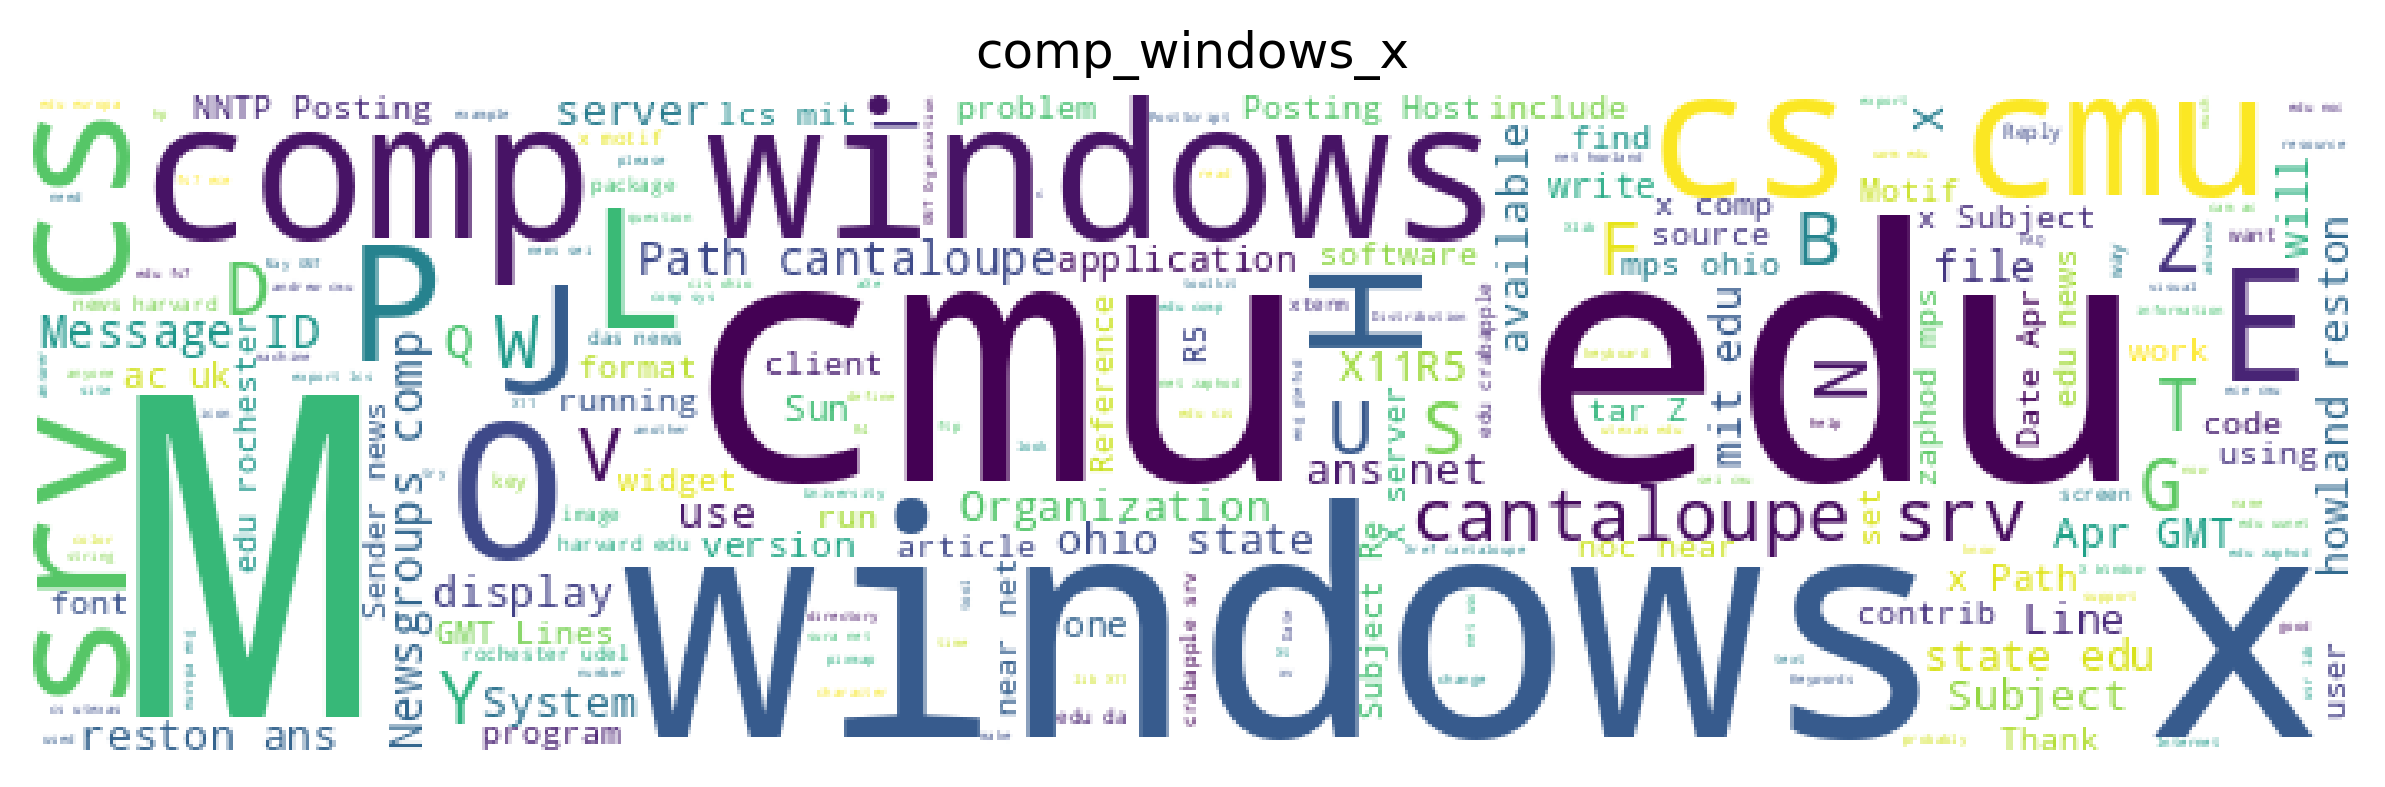


-------------------------------------------------------------------------------------------------------------------------------------------------------------------



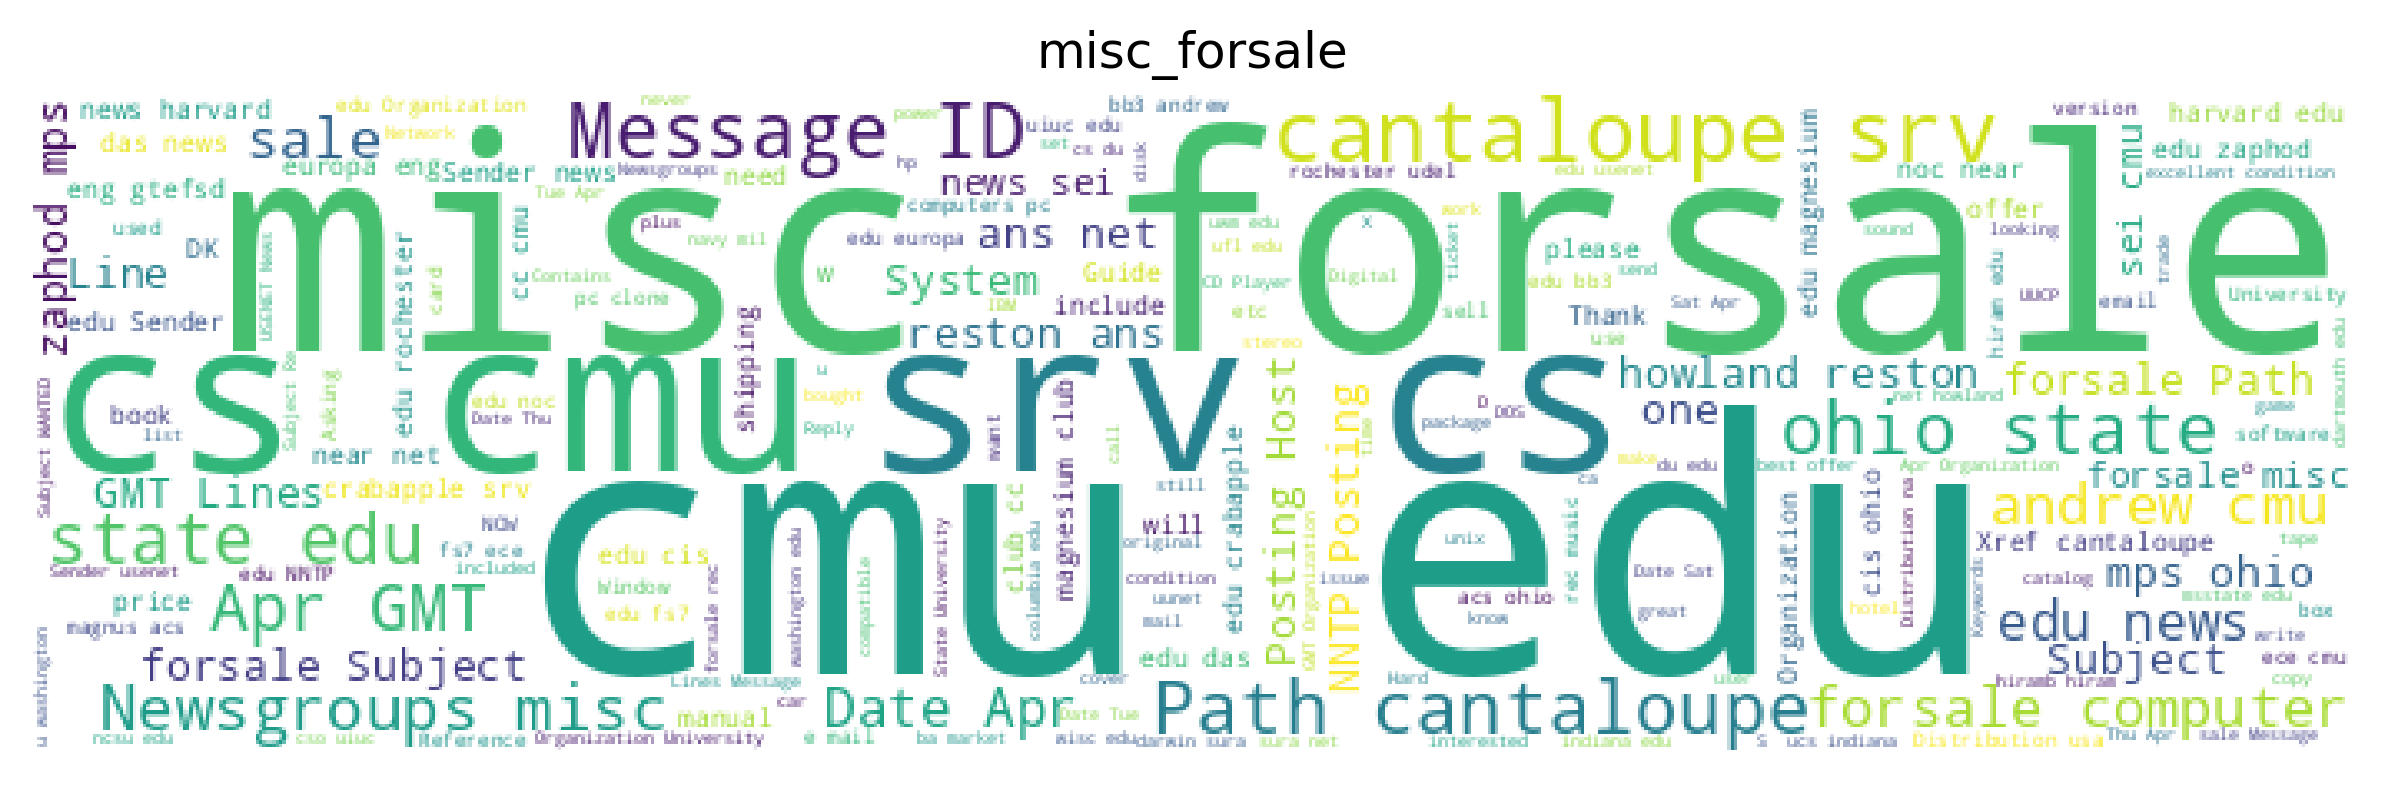


-------------------------------------------------------------------------------------------------------------------------------------------------------------------



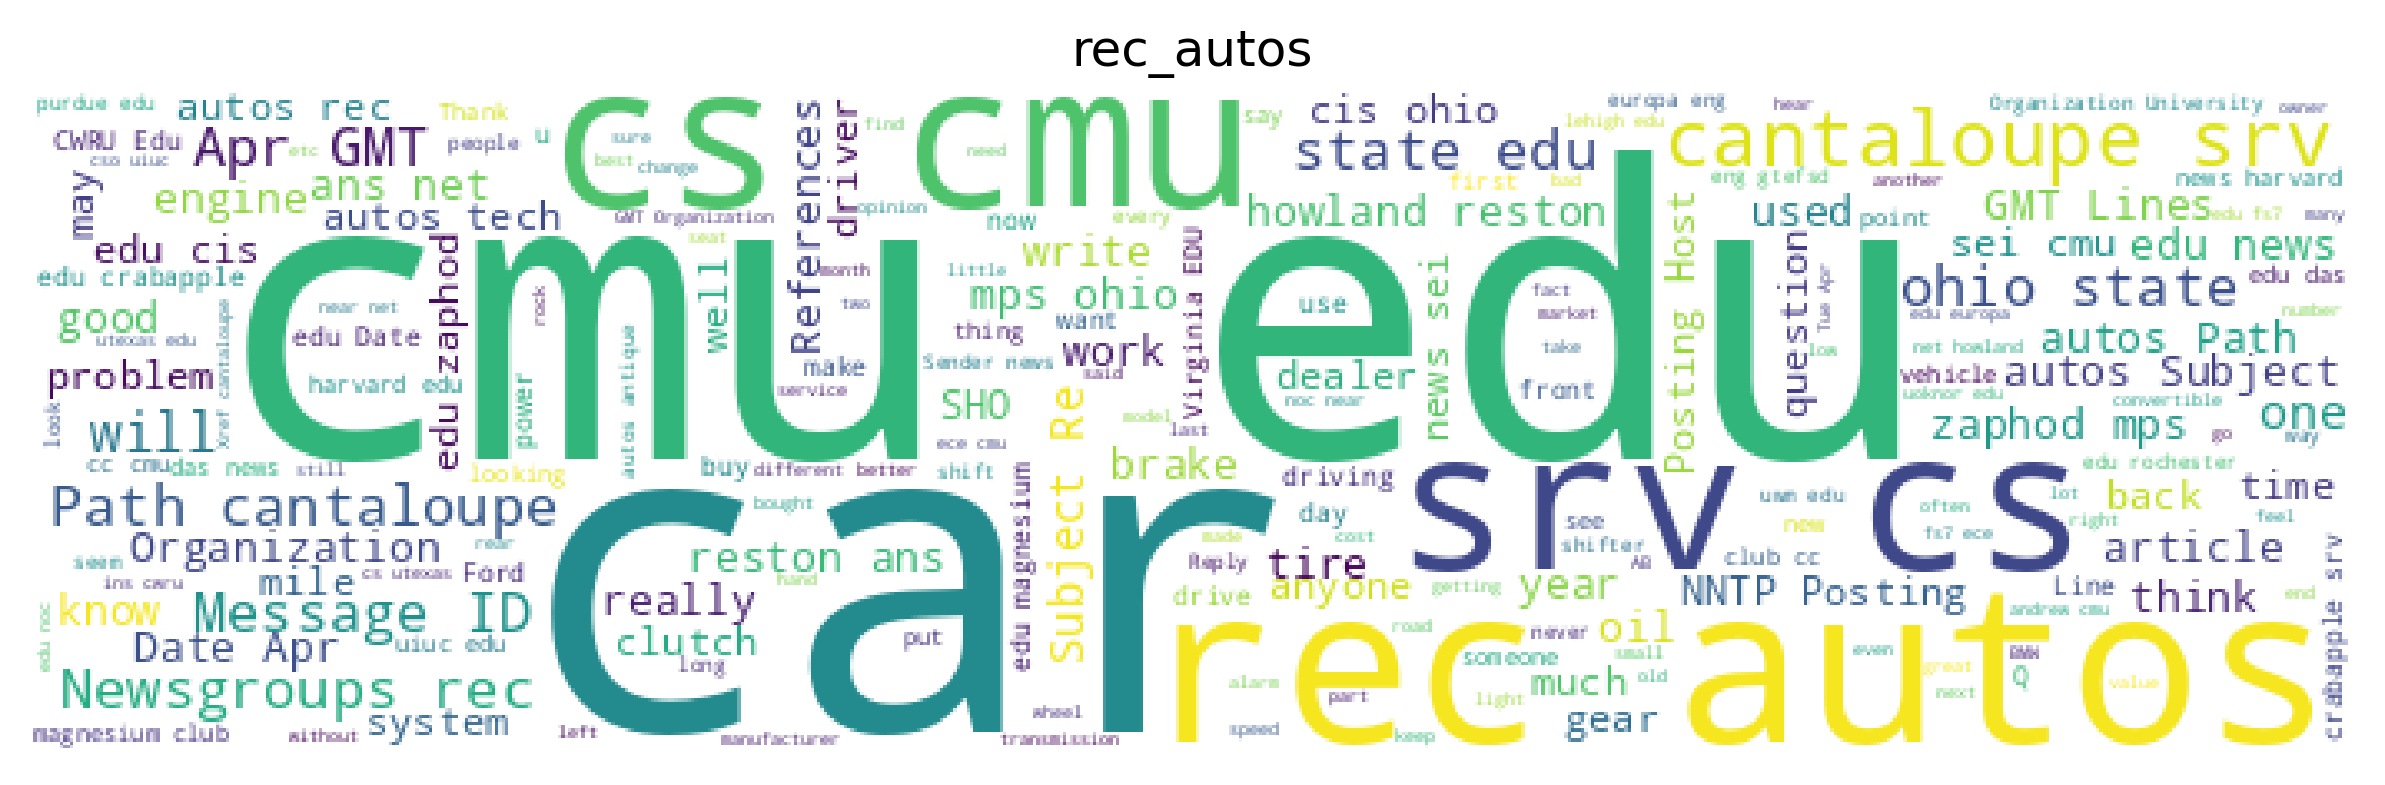


-------------------------------------------------------------------------------------------------------------------------------------------------------------------



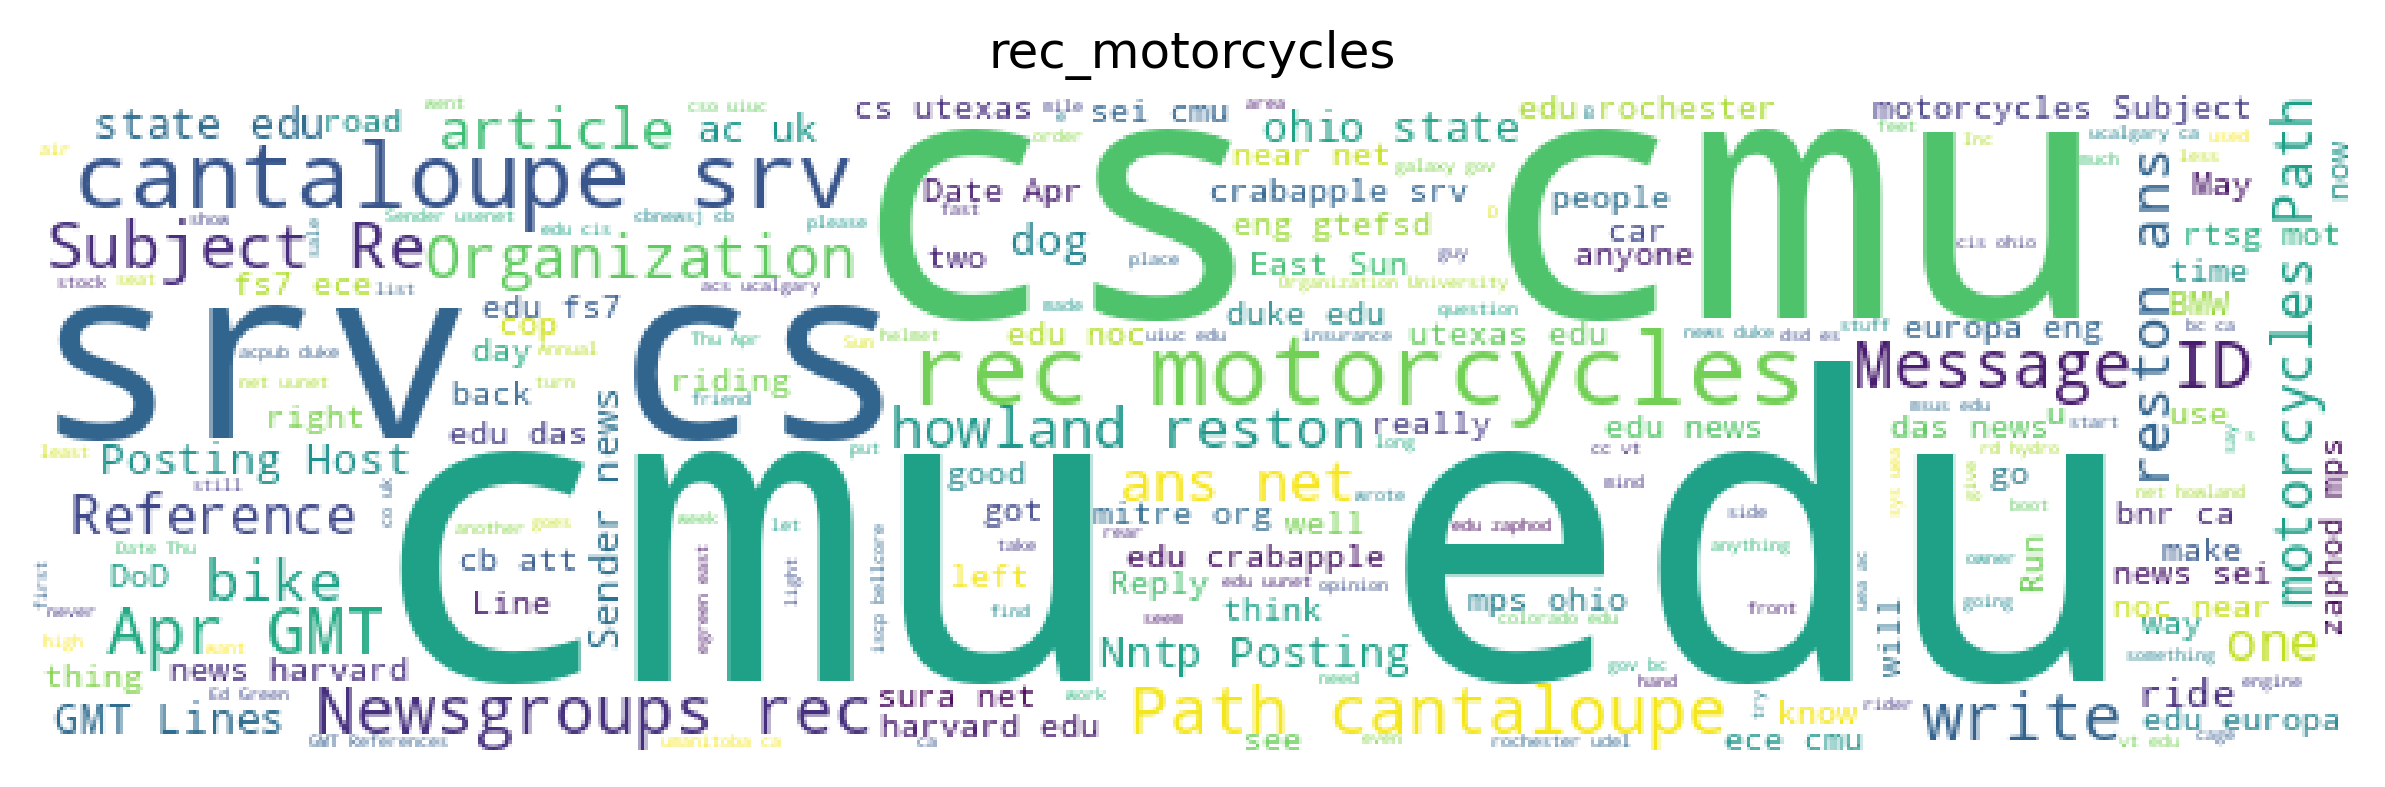


-------------------------------------------------------------------------------------------------------------------------------------------------------------------



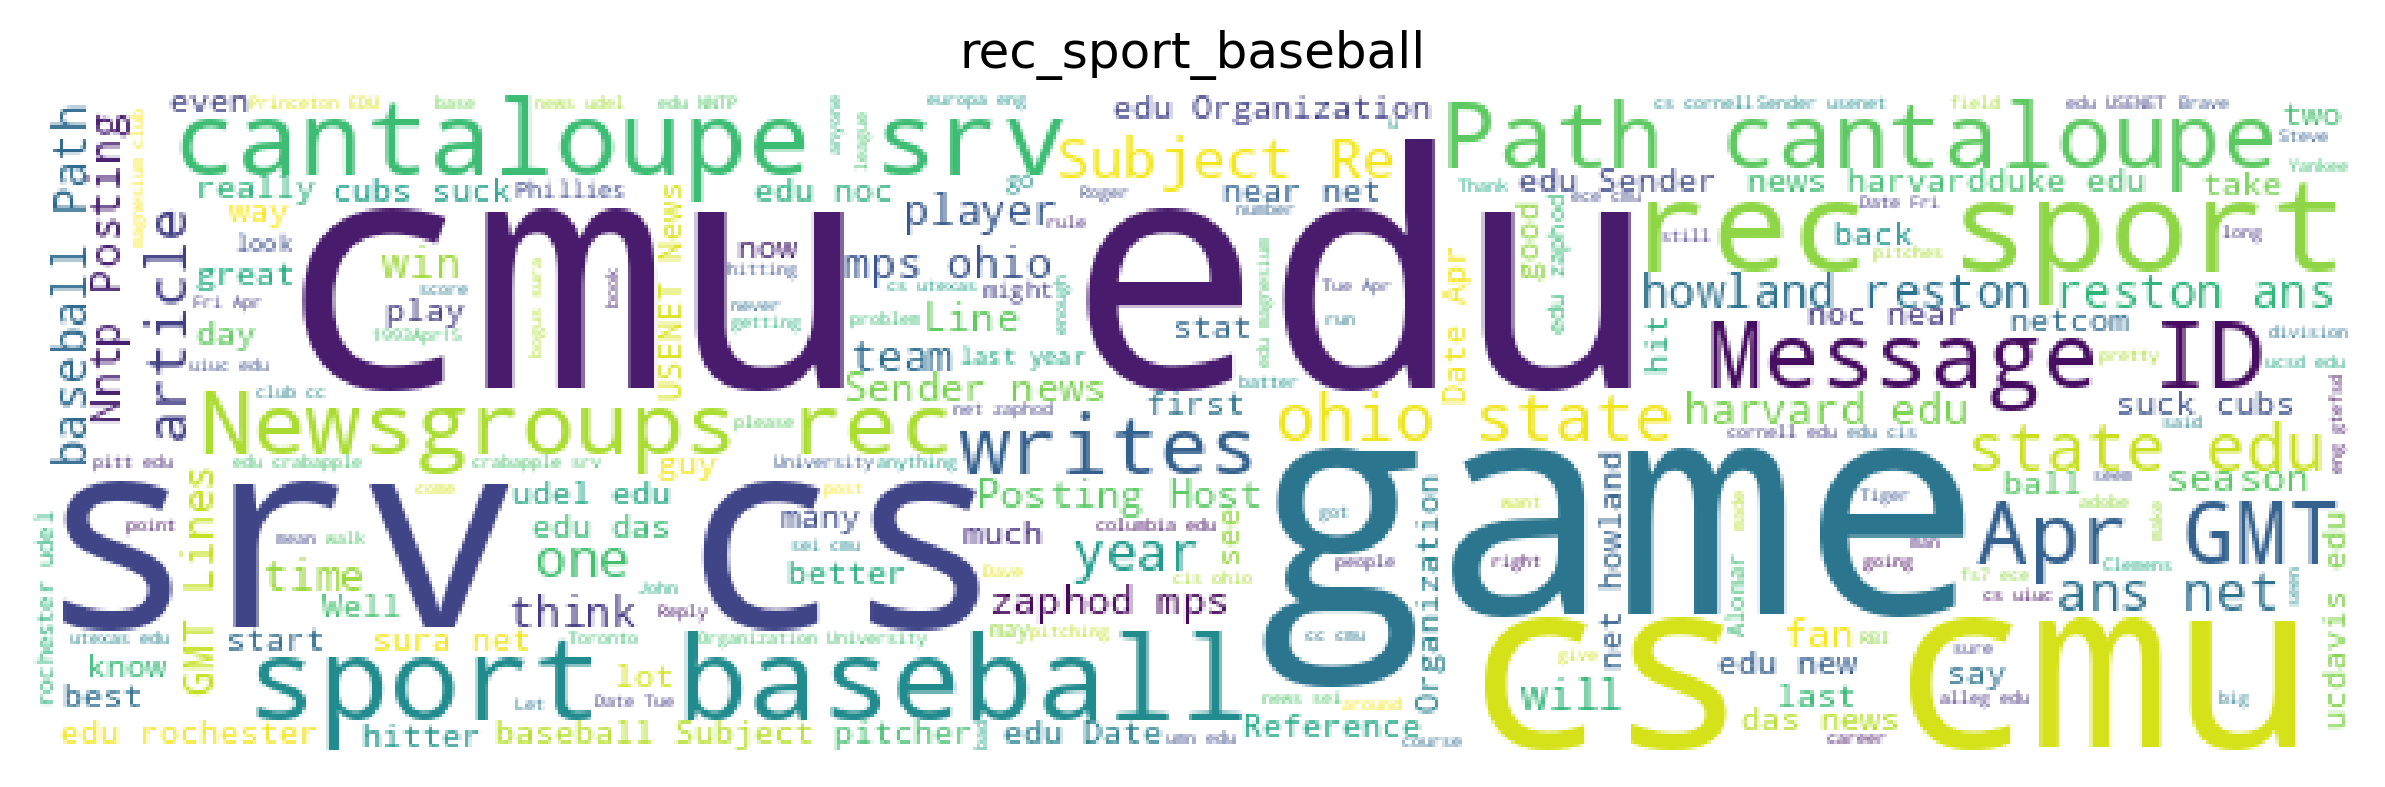


-------------------------------------------------------------------------------------------------------------------------------------------------------------------



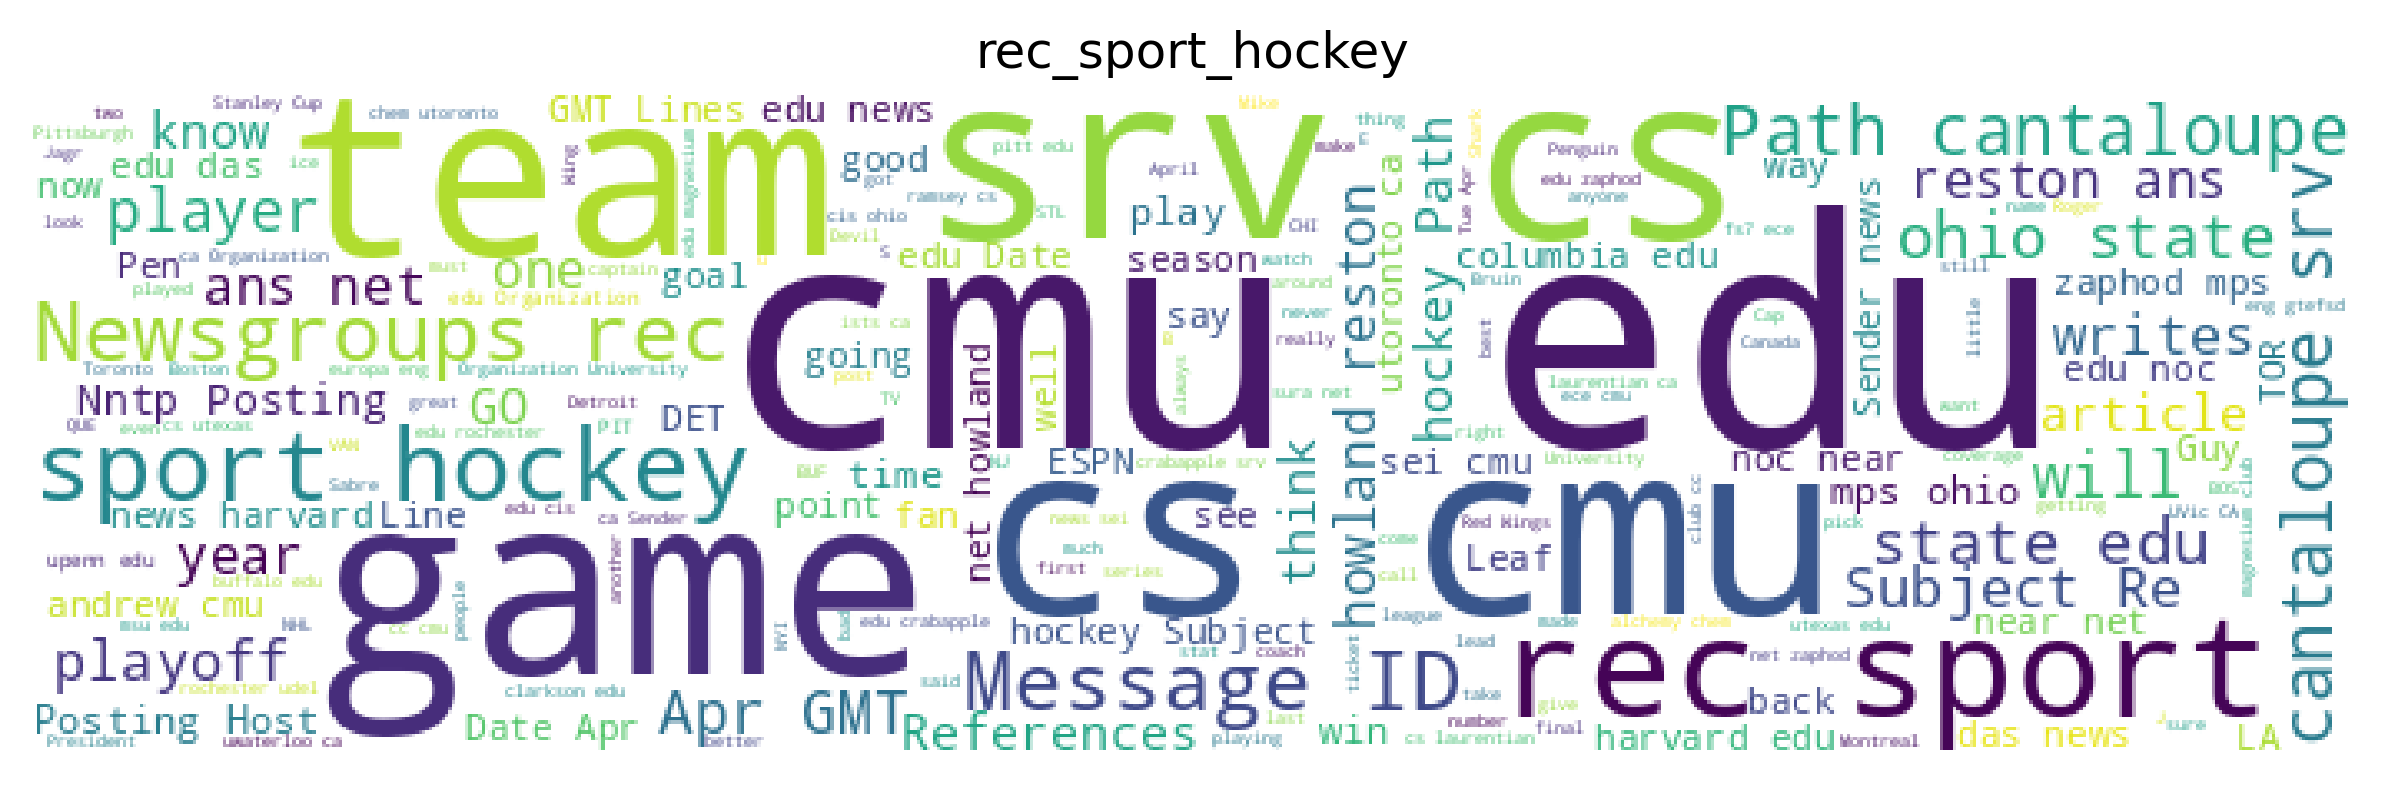


-------------------------------------------------------------------------------------------------------------------------------------------------------------------



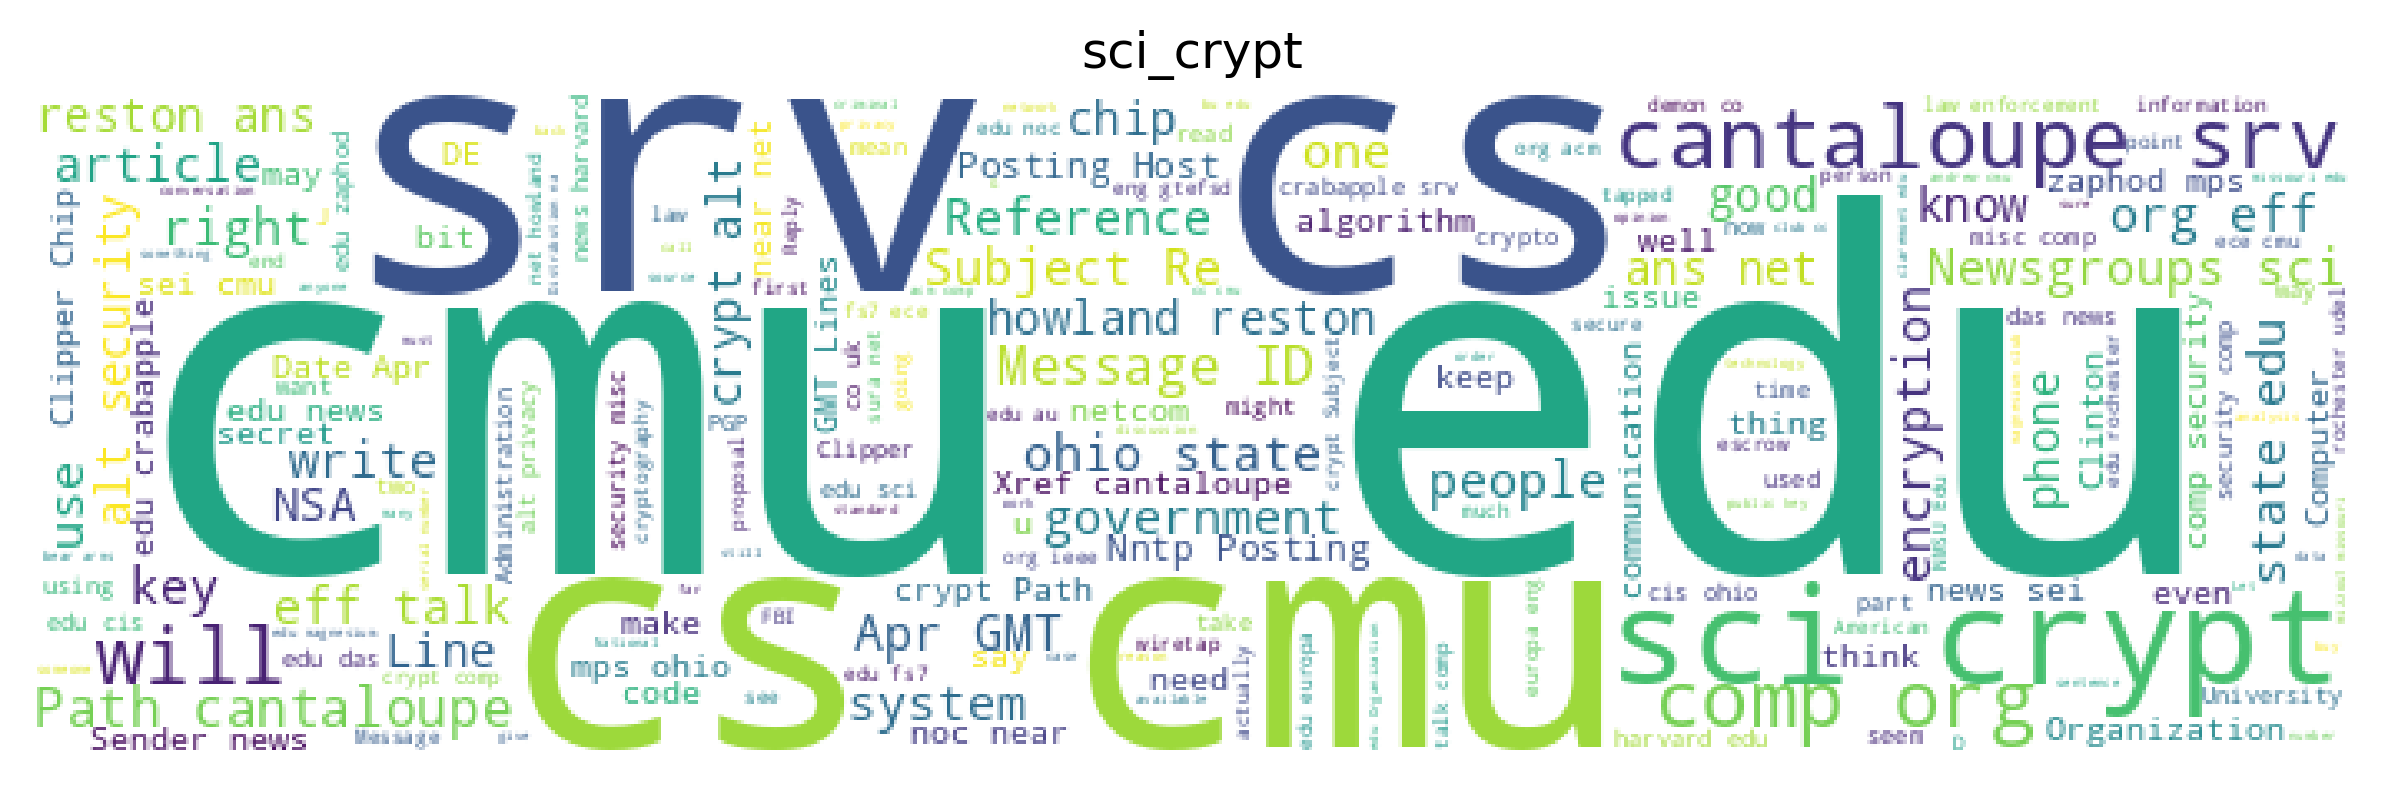


-------------------------------------------------------------------------------------------------------------------------------------------------------------------



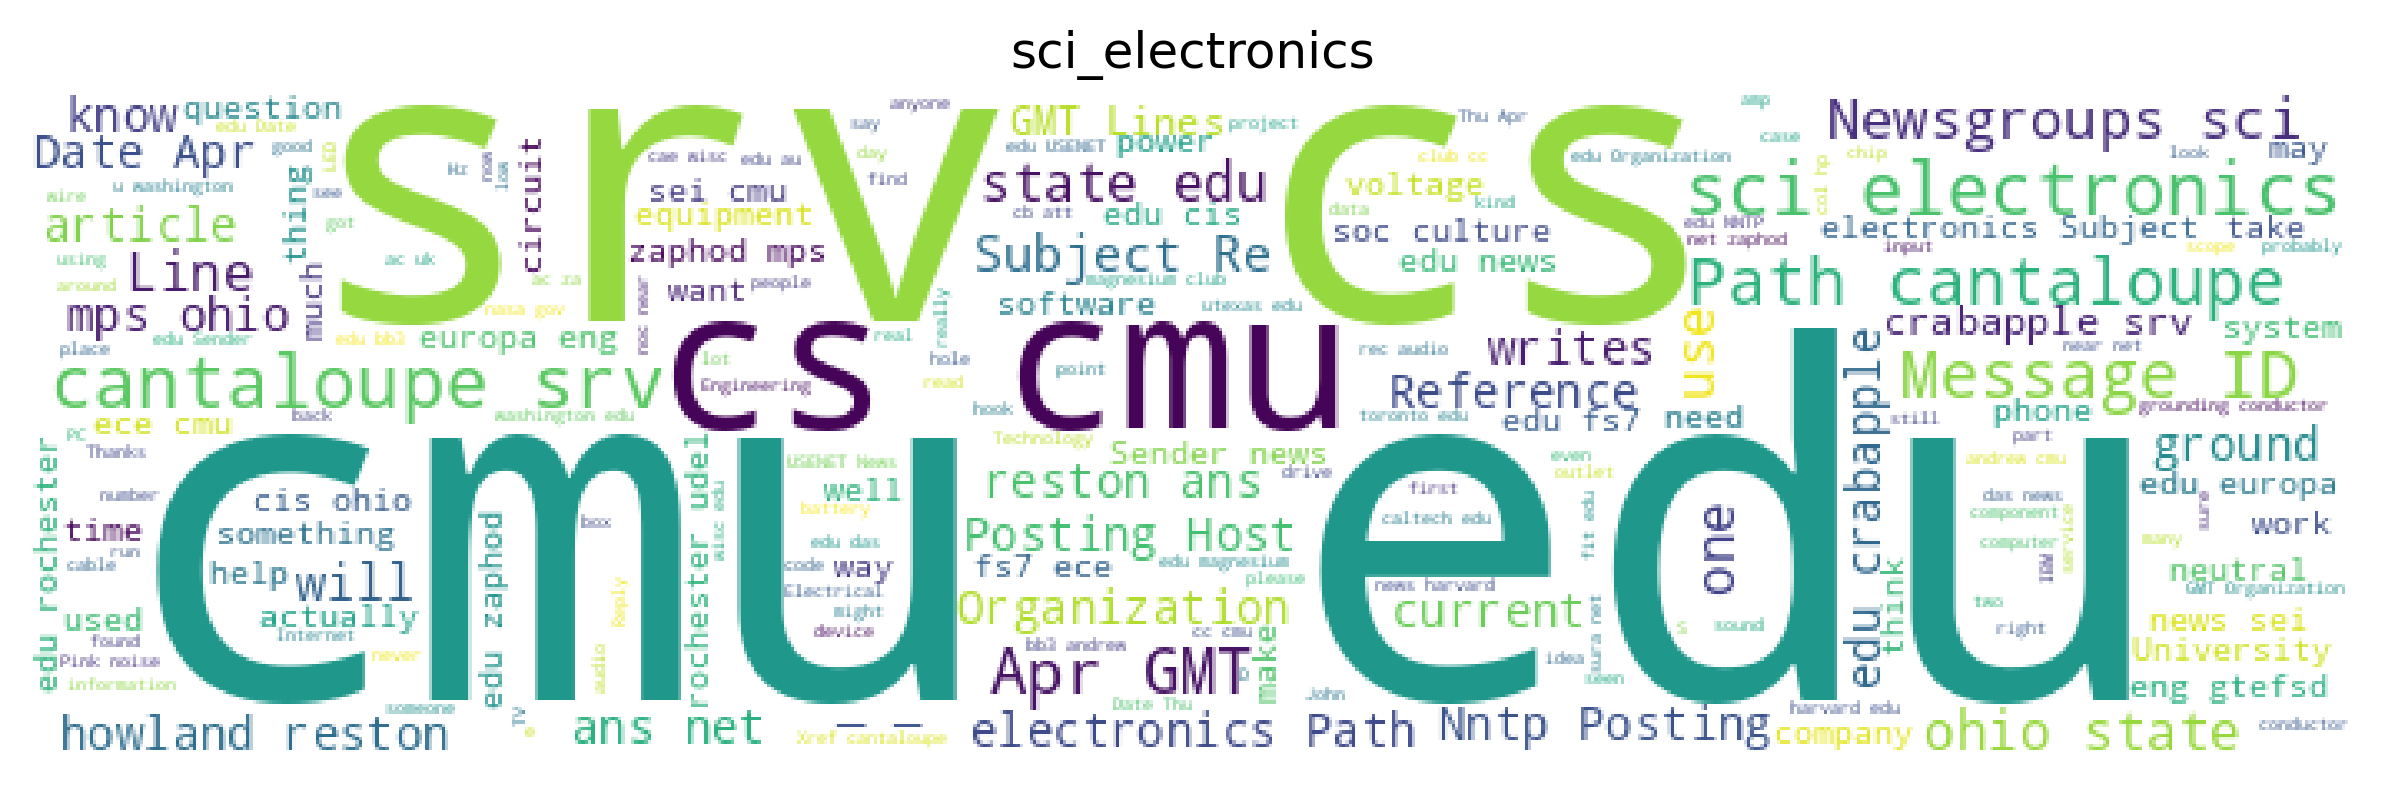


-------------------------------------------------------------------------------------------------------------------------------------------------------------------



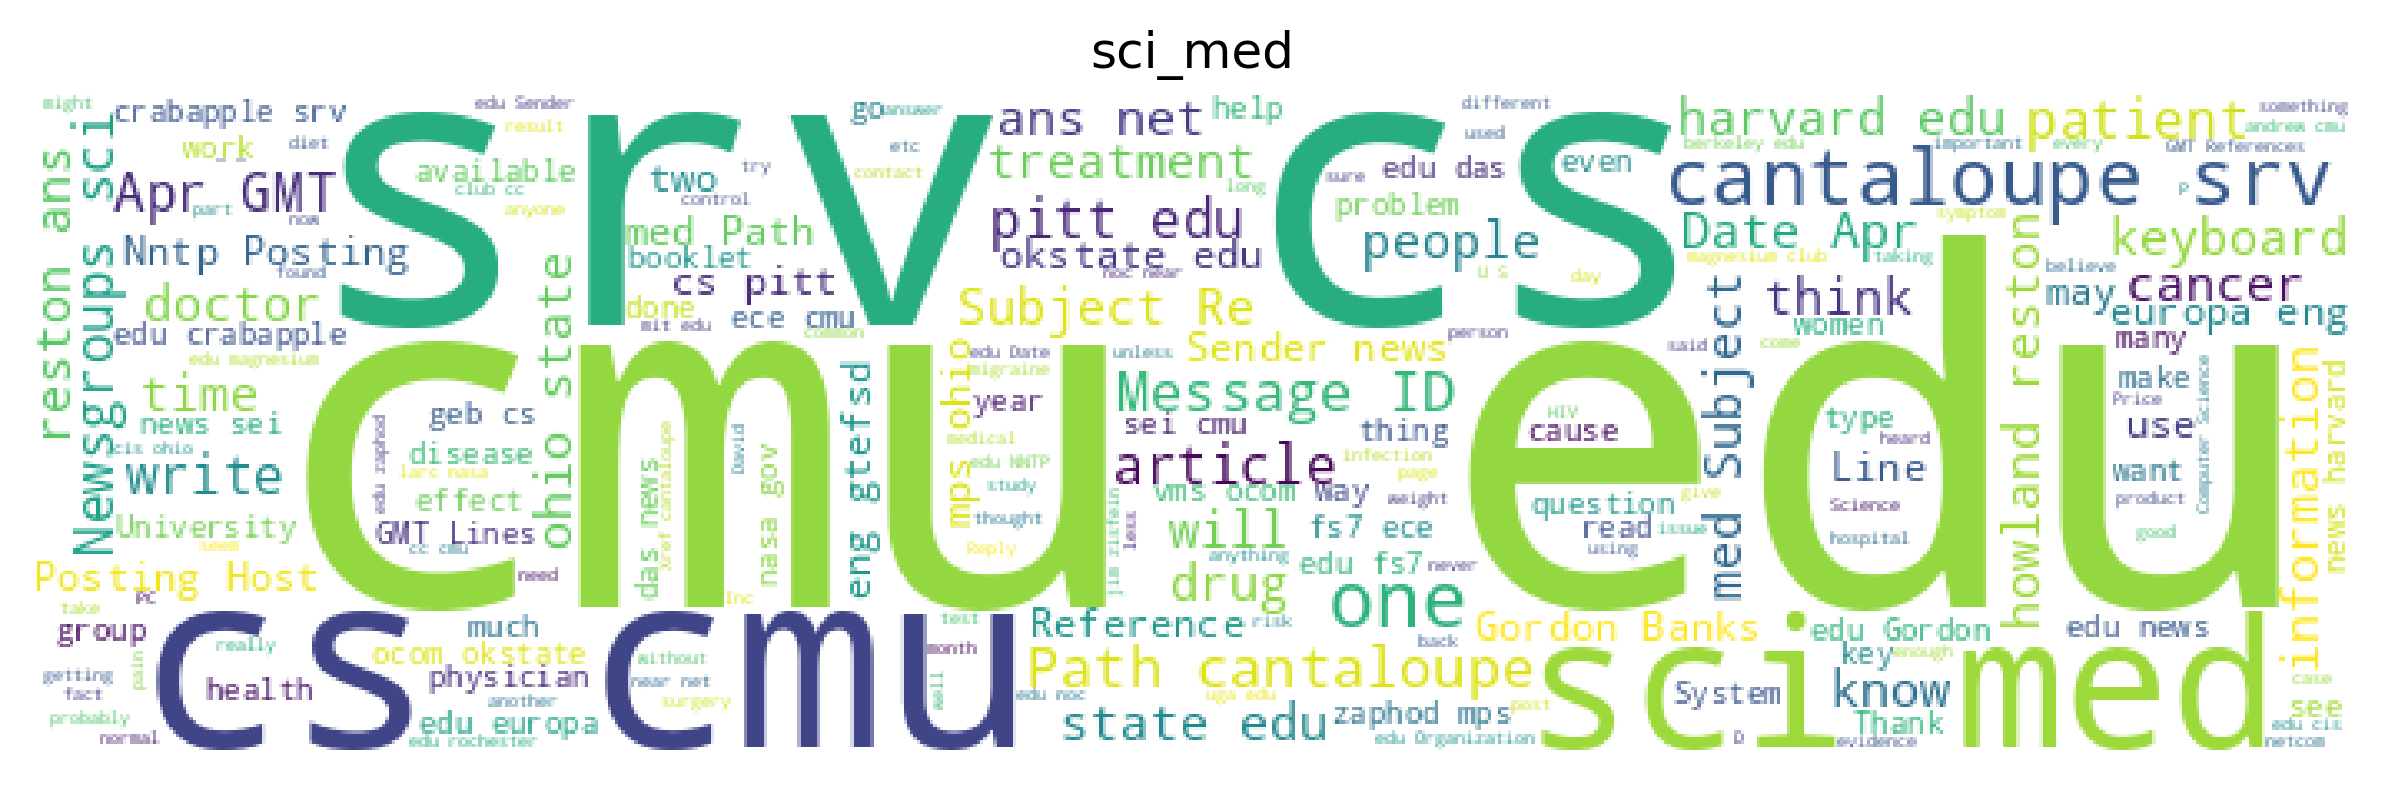


-------------------------------------------------------------------------------------------------------------------------------------------------------------------



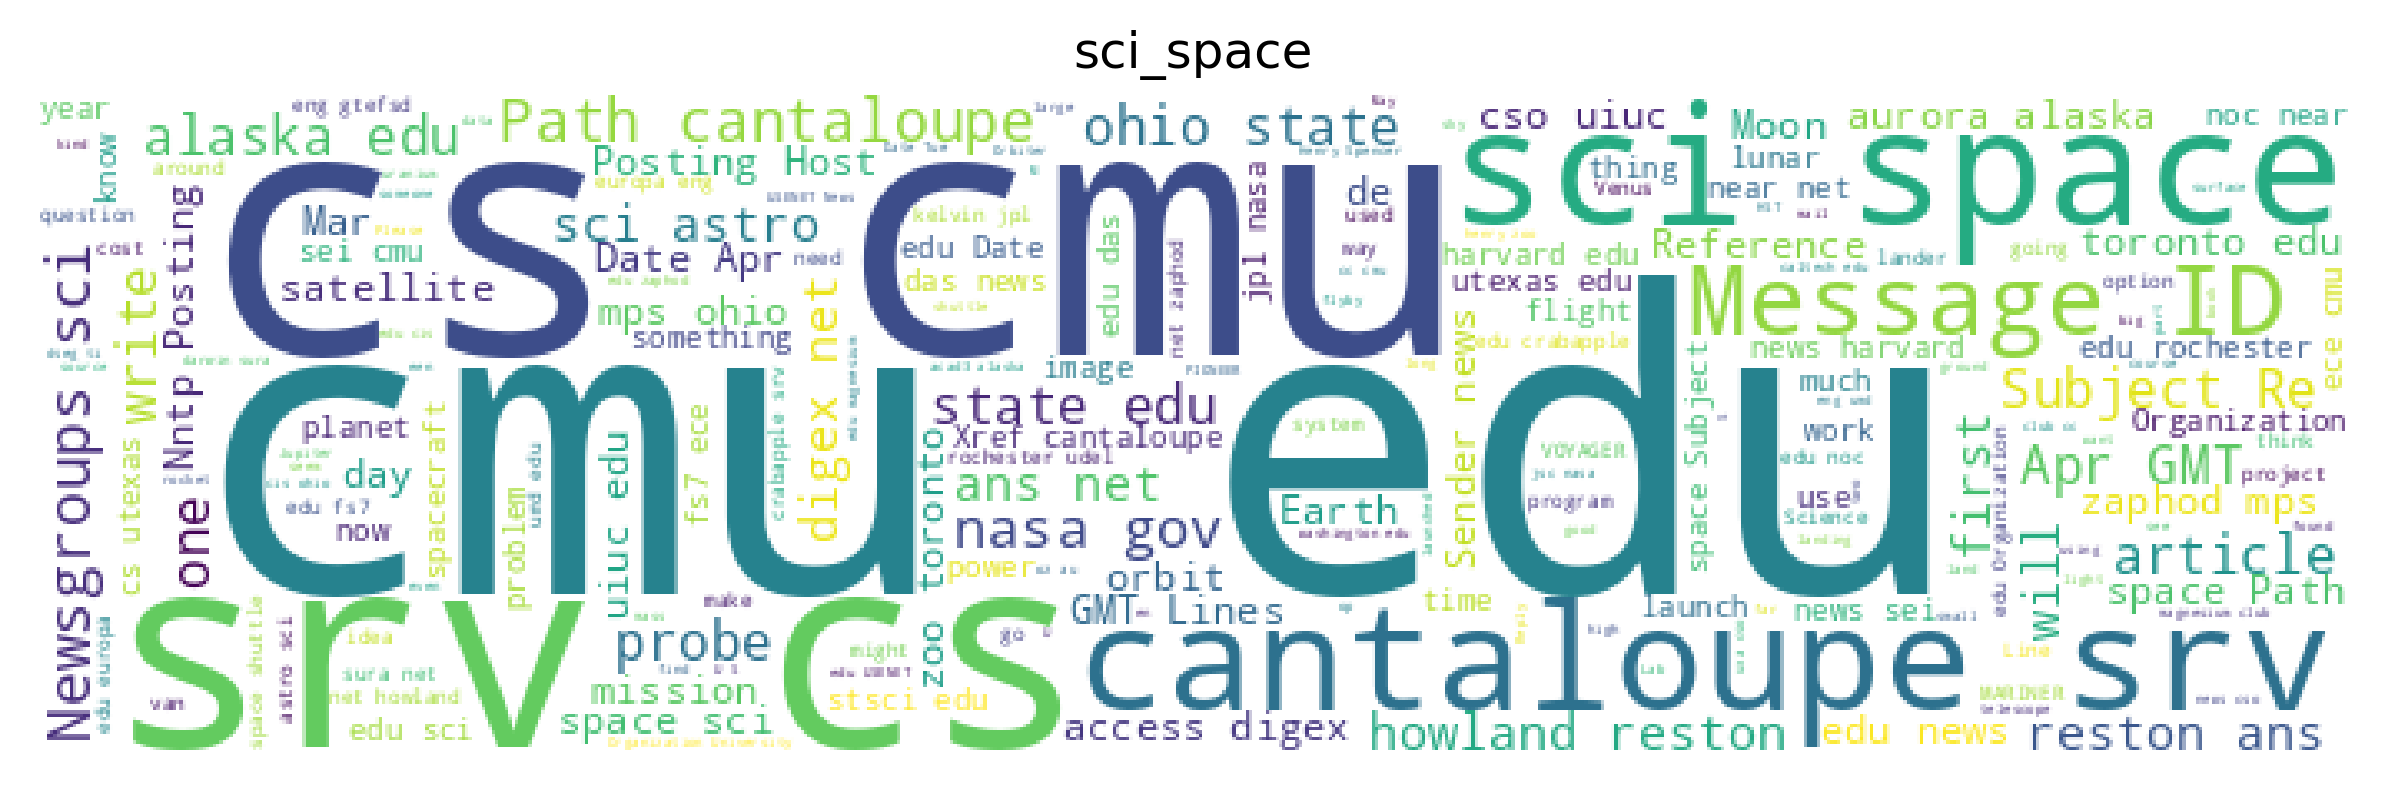


-------------------------------------------------------------------------------------------------------------------------------------------------------------------



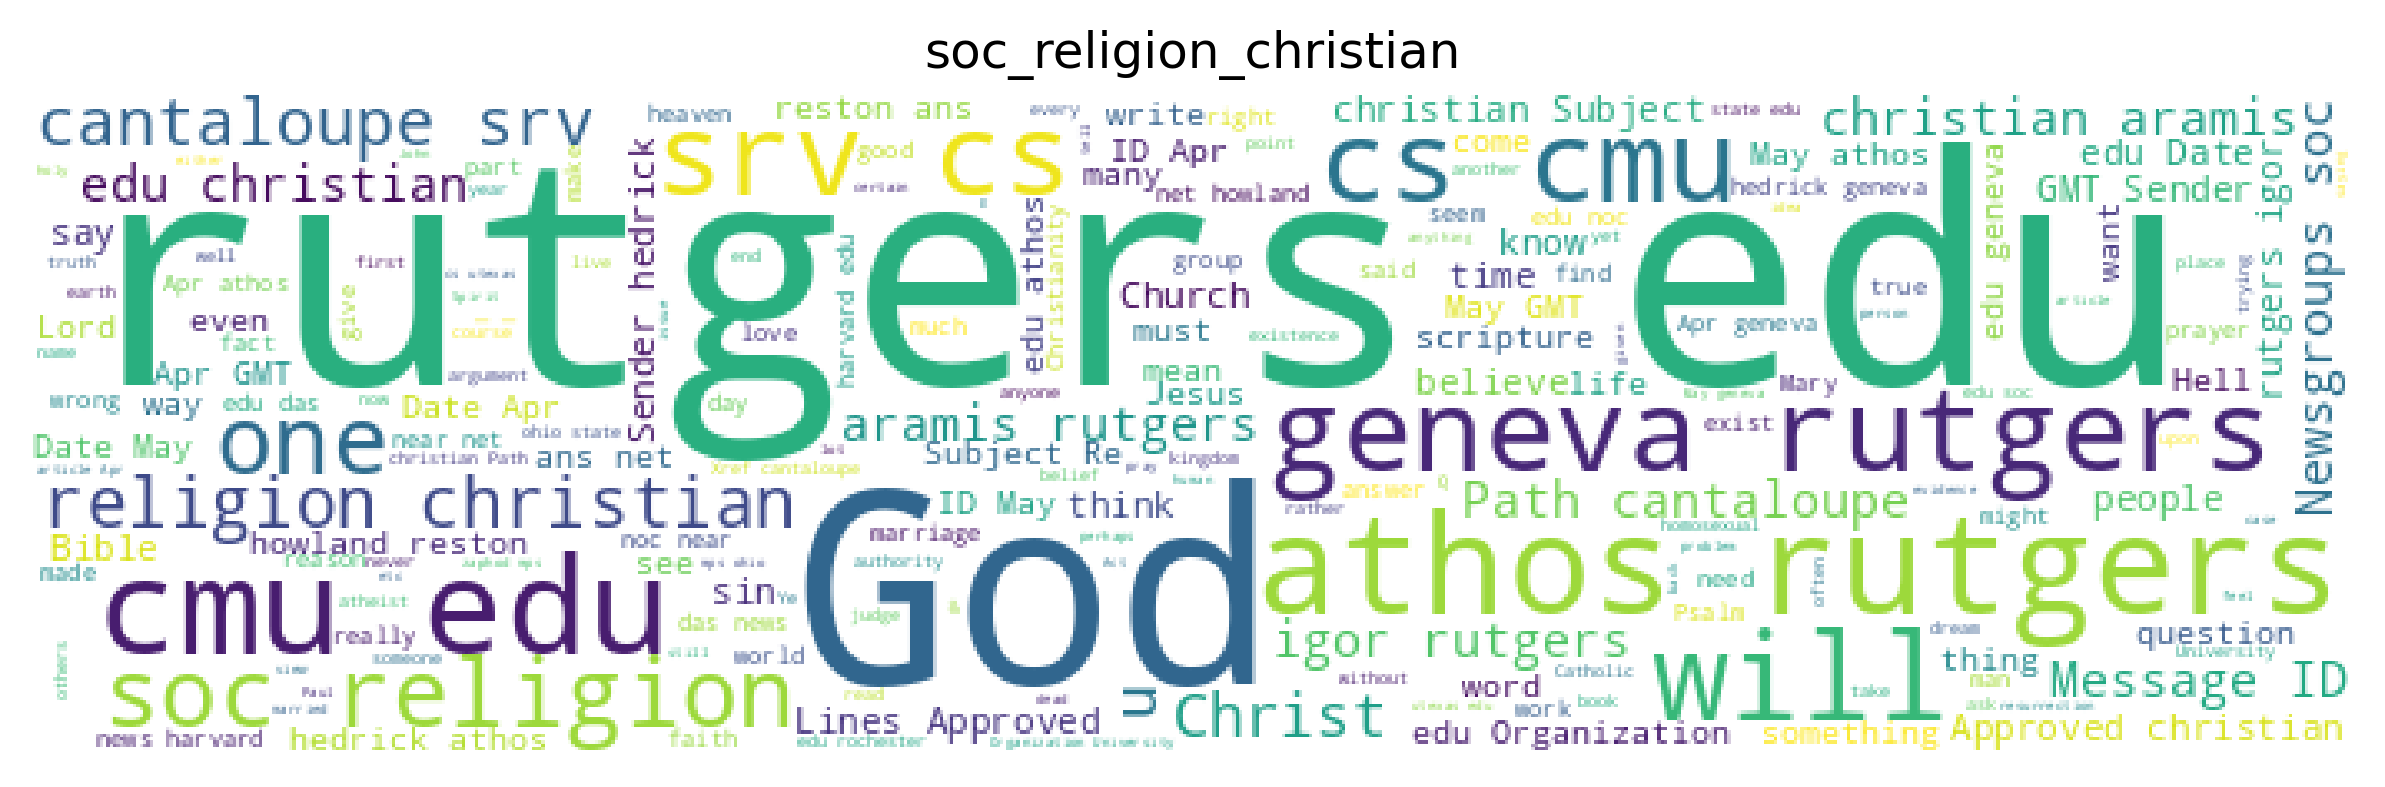


-------------------------------------------------------------------------------------------------------------------------------------------------------------------



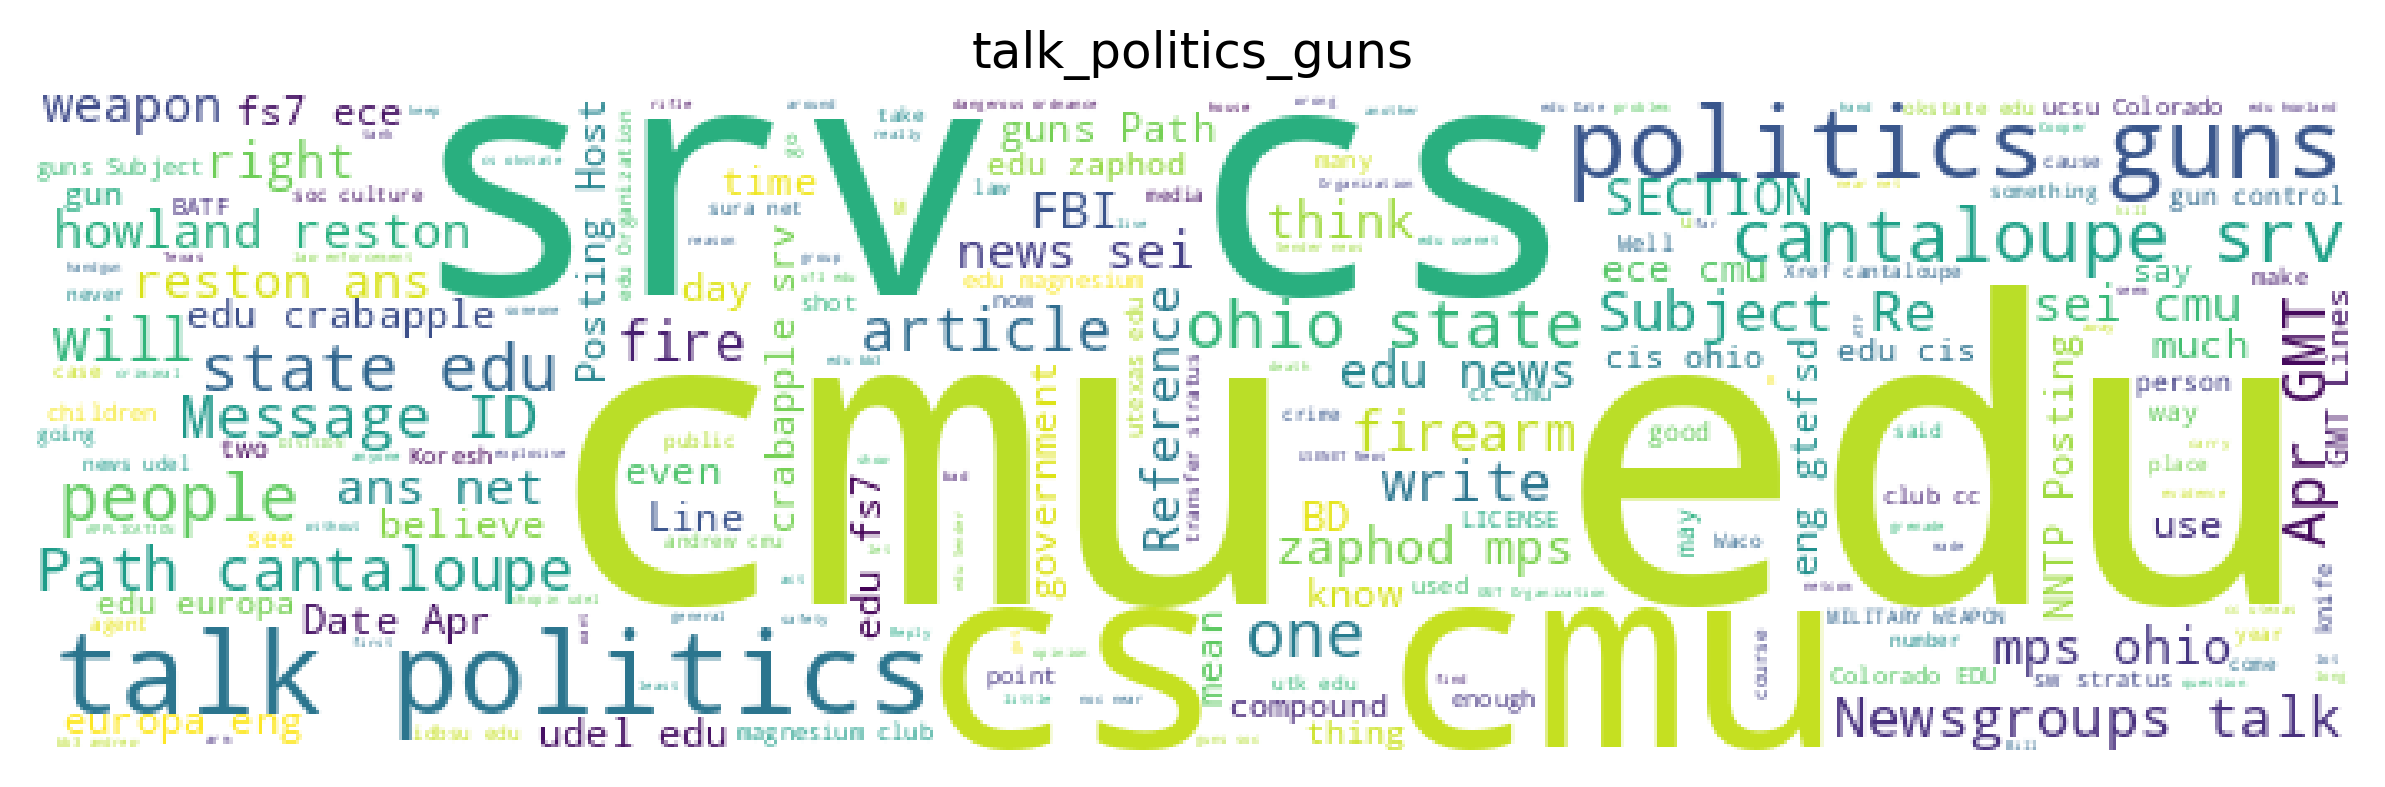


-------------------------------------------------------------------------------------------------------------------------------------------------------------------



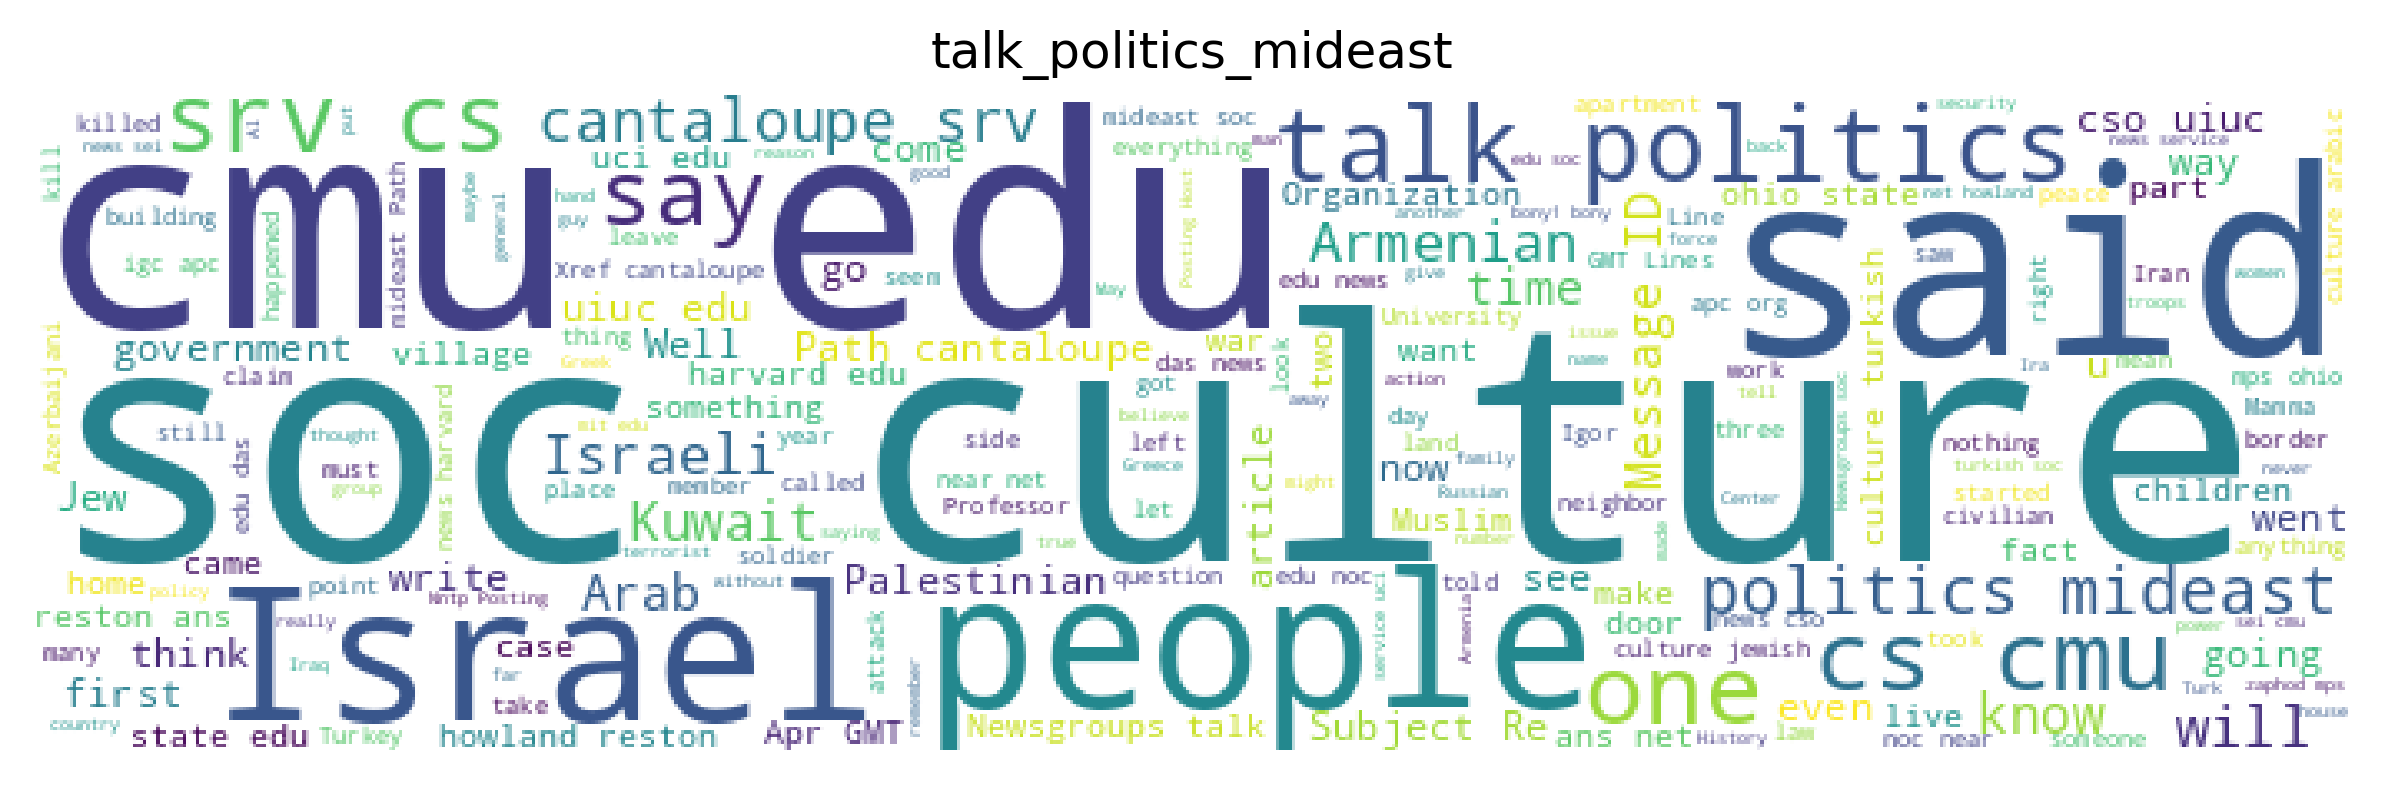


-------------------------------------------------------------------------------------------------------------------------------------------------------------------



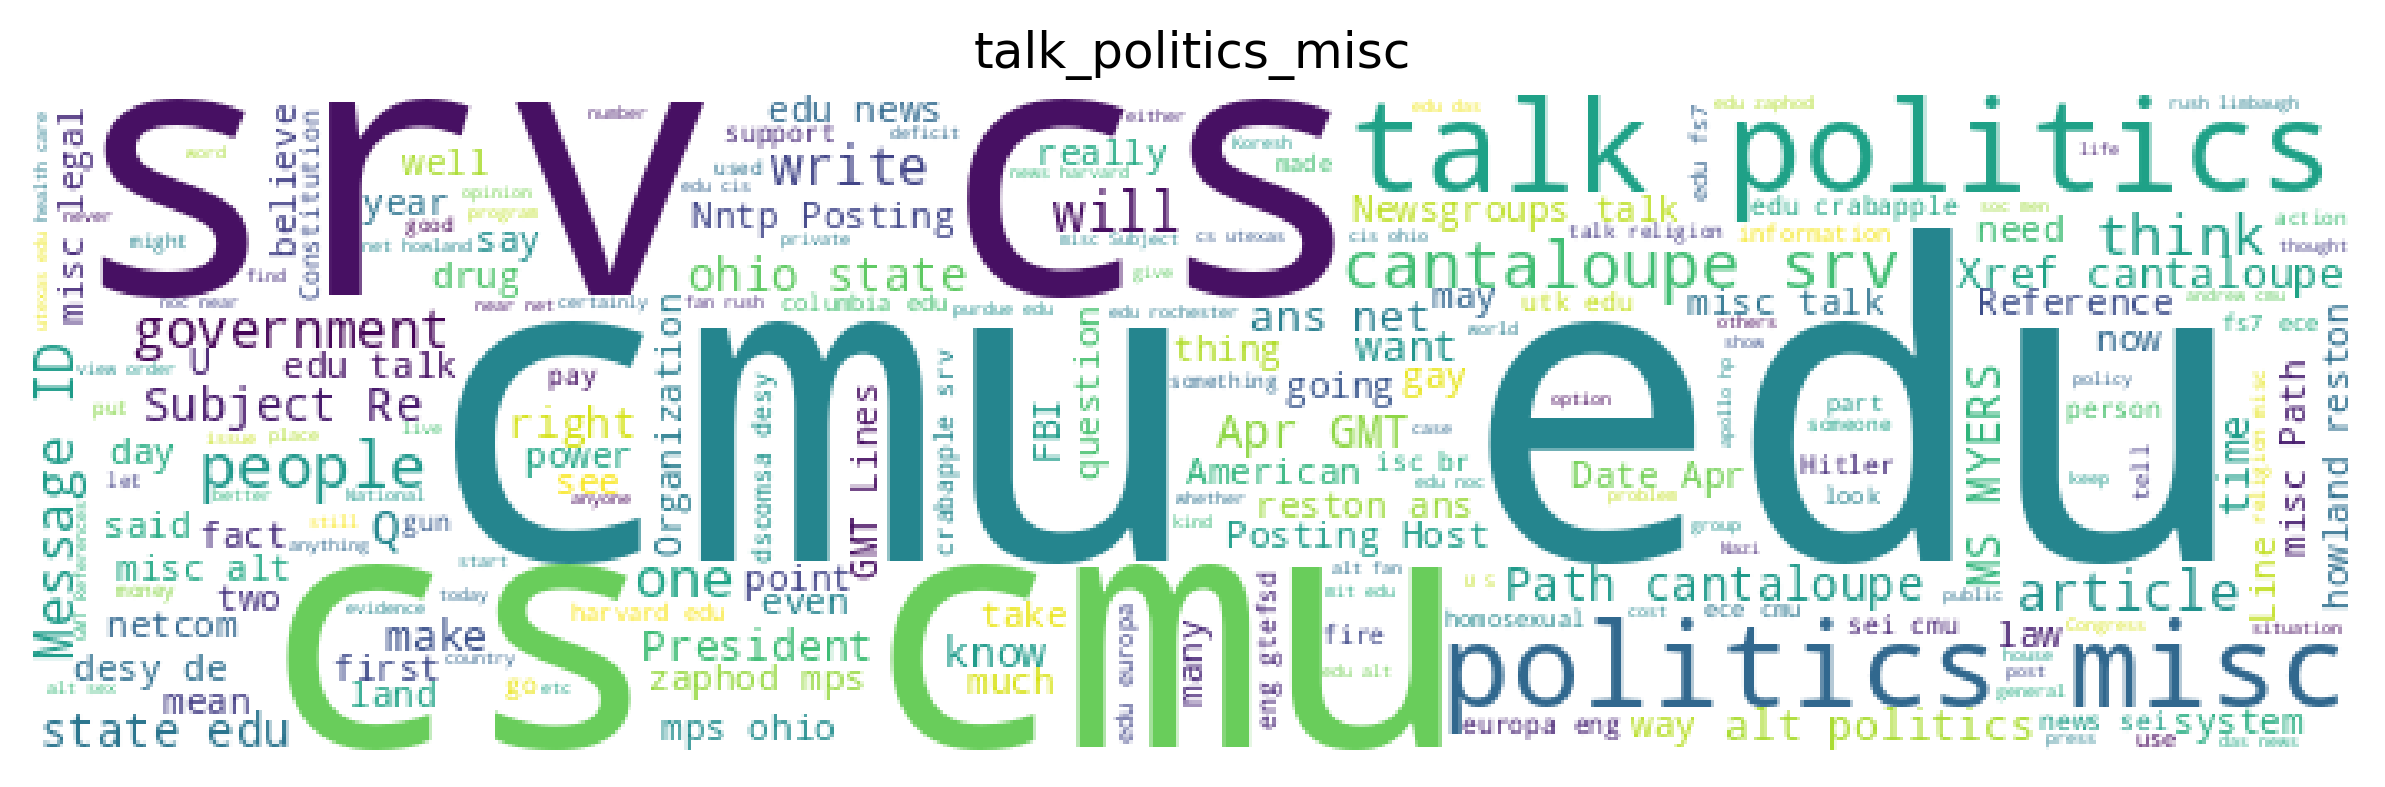


-------------------------------------------------------------------------------------------------------------------------------------------------------------------



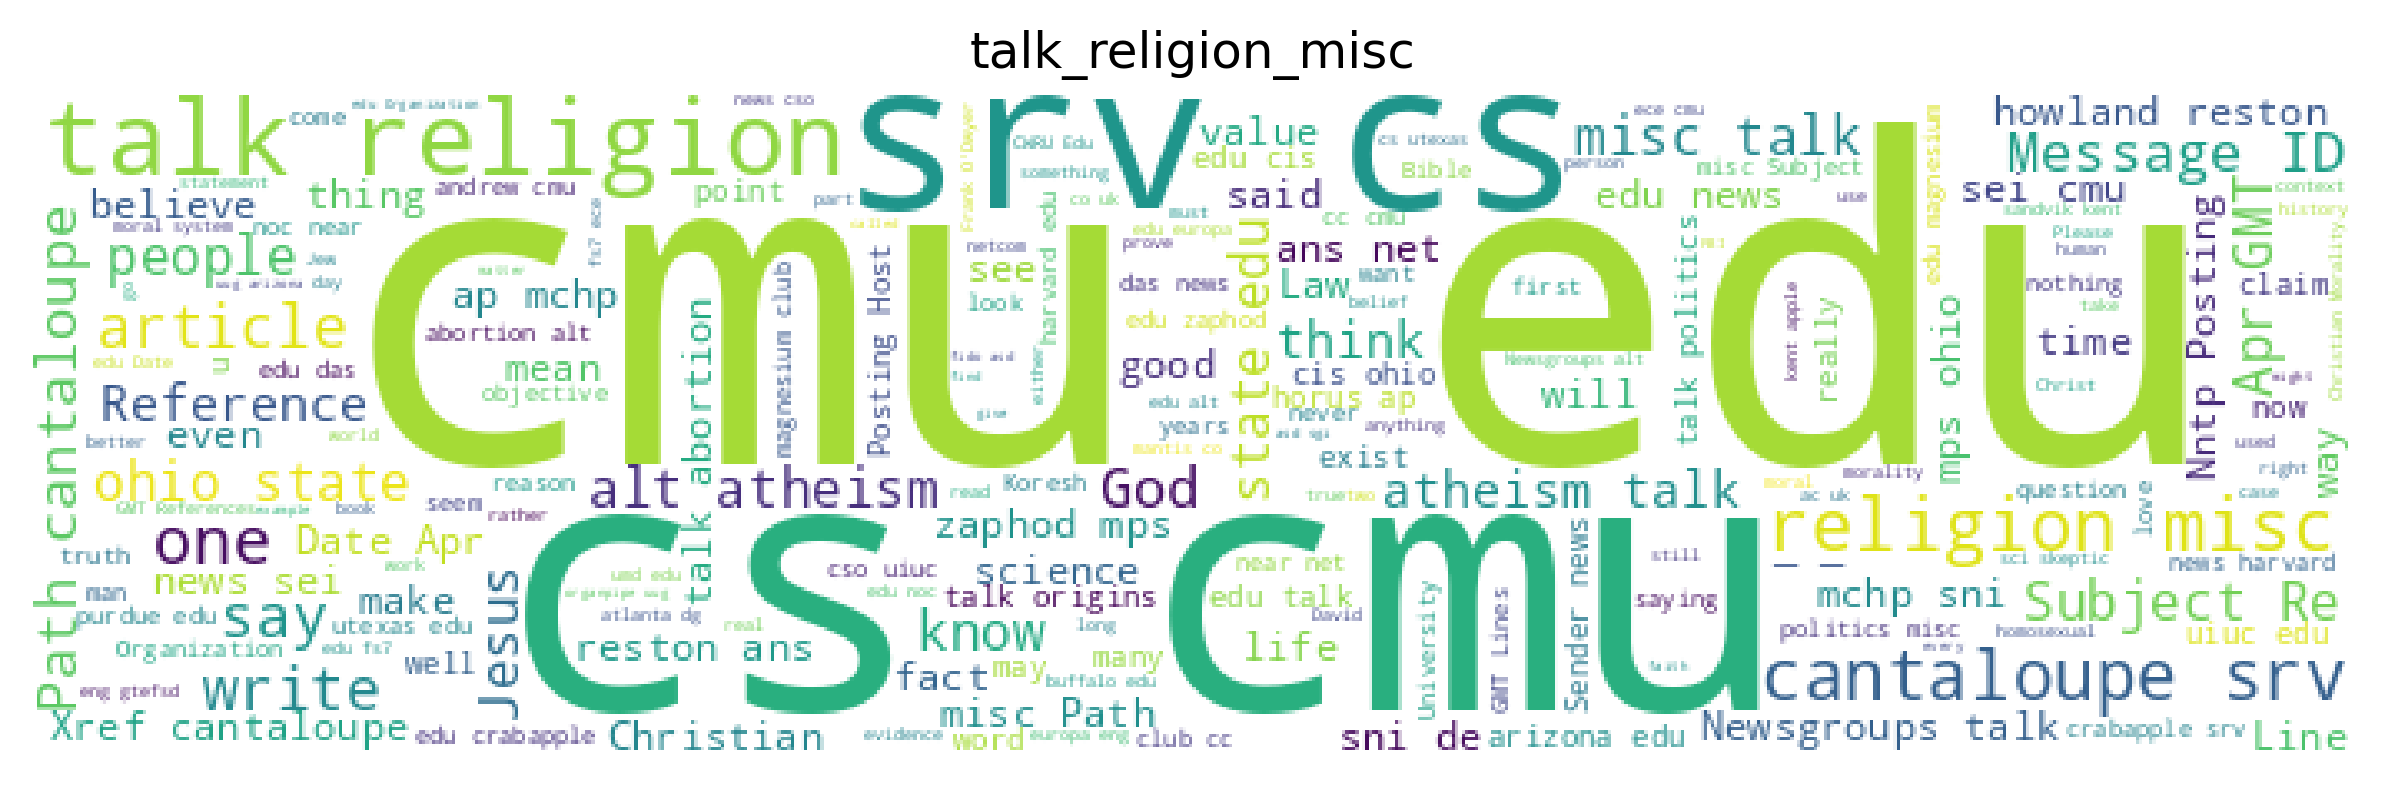


-------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [11]:
#worldcl plot
def worldcl(data,heading):
    txt = ' '.join(data['Data']) #Extracts the text data from the 'Data' column of the data DataFrame and joins it into a single string separated by spaces.
    wc = WordCloud(background_color='white',width=700, height=200,
                  colormap='viridis').generate(txt) #Generates the word cloud based on the provided text data.

    plt.imshow(wc) #Displays the generated word cloud as an image.
    plt.axis('off')
    plt.title(heading)

# This code iterates through each unique label in the 'Labels' column of the DataFrame.
for label in new_labels.values():
    df_label = df[df['Labels'] == label] # For each label, it filters the DataFrame to only include rows with that label.
    worldcl(df_label,label)  # It then calls the `worldcl` function to generate a word cloud for the text data in the filtered DataFrame.
    plt.show() # Finally, it displays the word cloud and prints a separator line.
    print()
    print('-------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print()

**Data preprocessing**


Preprocess the data by cleaning the text (removing punctuation, converting to lowercase, etc.), tokenizing, and removing stopwords.

In [12]:
# Import necessary libraries
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required resources
nltk.download('stopwords')  # Download the stopwords corpus
nltk.download('wordnet')  # Download the wordnet corpus for lemmatization

# Initialize the lemmatizer
lemma = WordNetLemmatizer()

# Create an empty list to store the processed text
corpus = []

# Loop through each row in the DataFrame
for i in range(len(df)):
    # Clean the text by removing non-alphabetic characters
    msg = re.sub('[^a-zA-Z]', ' ', df['Data'][i])

    # Convert the text to lowercase for consistency
    msg = msg.lower()

    # Split the text into individual words (tokenization)
    msg = msg.split()

    # Remove stopwords (common words that don't add value)
    msg = [word for word in msg if word not in stopwords.words('english')]

    # Lemmatize the words to their base form (e.g., "running" -> "run")
    msg = [lemma.lemmatize(word) for word in msg]

    # Join the processed words back into a single string
    msg = ' '.join(msg)
    # Add the processed text to the corpus
    corpus.append(msg)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


**Model Building**


In [13]:
y = df['Num_labels']
y

0        1
1        1
2        1
3        1
4        1
        ..
1995    20
1996    20
1997    20
1998    20
1999    20
Name: Num_labels, Length: 2000, dtype: int64

In [14]:
# @markdown **TfidfVectorizer** is a tool provided by the scikit-learn library in Python, that converts a collection of raw documents into a matrix of TF-IDF (Term Frequency-Inverse Document Frequency) features.
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TfidfVectorizer object with specified parameters
tf = TfidfVectorizer(
    max_features=4000,        # Maximum number of features (words/terms) to be considered
    ngram_range=(1, 5),       # Consider unigrams, bigrams, trigrams, 4-grams, and 5-grams
    stop_words='english',     # Use built-in list of English stop words to remove common words like 'the', 'is', etc.
    norm='l2',                # Apply L2 normalization to the term frequencies
    max_df=0.8,               # Ignore terms that appear in more than 80% of the documents
    analyzer='word'           # Analyze words (as opposed to characters or character n-grams)
)

# Fit the vectorizer to the corpus
tf.fit(corpus)

# Transform the corpus into a TF-IDF feature matrix
X_data = tf.fit_transform(corpus)

X_data.shape


(2000, 4000)

In [15]:
X_train,X_test,y_train,y_test = train_test_split(X_data,y,test_size=0.2, random_state=1)
print('X_train shape :',X_train.shape)
print('X_test shape :',X_test.shape)
print('y_train shape :',y_train.shape)
print('y_test shape :',y_test.shape)

X_train shape : (1600, 4000)
X_test shape : (400, 4000)
y_train shape : (1600,)
y_test shape : (400,)


In [16]:
def hyperparameter_tuning_1(model, params, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):

    gscv=GridSearchCV(model,params,scoring='accuracy',cv=20,return_train_score=True, verbose=1)
    gscv.fit(X_train,y_train)
    ypred = gscv.predict(X_test)
    print("1) Best Score :", gscv.best_score_)
    print("2) Best Parameters :",gscv.best_params_)
    print(f"3) Train Accuracy: {gscv.score(X_train,y_train)}\nTest Accuracy: {gscv.score(X_test,y_test)}")
    return gscv.best_params_


def hyperparameter_tuning_2(model, params, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    # Convert X_train and X_test to dense arrays if they are sparse
    if hasattr(X_train, 'toarray'):
        X_train = X_train.toarray()
    if hasattr(X_test, 'toarray'):
        X_test = X_test.toarray()

    gscv=GridSearchCV(model,params,scoring='accuracy',cv=20,return_train_score=True)
    gscv.fit(X_train,y_train)
    ypred = gscv.predict(X_test)
    print("1) Best Score :", gscv.best_score_)
    print("2) Best Parameters :",gscv.best_params_)
    print(f"3) Train Accuracy: {gscv.score(X_train,y_train)}\nTest Accuracy: {gscv.score(X_test,y_test)}")
    return gscv.best_params_

In [17]:

bnb = BernoulliNB()
params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'binarize': [None, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'fit_prior': [False],
    'class_prior':[None],
    'force_alpha': [True],
    }

bnb_best_params = hyperparameter_tuning_1(bnb, params, X_train, y_train, X_test, y_test)


Fitting 20 folds for each of 72 candidates, totalling 1440 fits
1) Best Score : 0.93125
2) Best Parameters : {'alpha': 0.01, 'binarize': 0.0, 'class_prior': None, 'fit_prior': False, 'force_alpha': True}
3) Train Accuracy: 0.9925
Test Accuracy: 0.96


In [20]:
gnb = GaussianNB()
params = {'priors': [None, {0: 0.5, 1: 0.5}],
          'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
          }

gnb_best_params = hyperparameter_tuning_2(gnb, params, X_train, y_train, X_test, y_test)


1) Best Score : 0.698125
2) Best Parameters : {'priors': None, 'var_smoothing': 0.01}
3) Train Accuracy: 0.995625
Test Accuracy: 0.7175


In [21]:
mnb=MultinomialNB()
params={'alpha': [ 0.001, 0.1, 1,2,3,4,5, 10,20,30,50,100],
       'force_alpha':[True, False],
       'fit_prior':[True, False],
       'class_prior':[None, {0: 0.5, 1: 0.5}]
       }

mnb_best_params = hyperparameter_tuning_1(mnb, params, X_train, y_train, X_test, y_test)

Fitting 20 folds for each of 96 candidates, totalling 1920 fits
1) Best Score : 0.928125
2) Best Parameters : {'alpha': 10, 'class_prior': None, 'fit_prior': False, 'force_alpha': True}
3) Train Accuracy: 0.961875
Test Accuracy: 0.92


In [22]:
#best model
best_model = BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=False, force_alpha=True)
best_model.fit(X_train,y_train)
ypred = best_model.predict(X_test)

print(f"Train Accuracy: {best_model.score(X_train,y_train)}\nTest Accuracy: {best_model.score(X_test,y_test)}")


Train Accuracy: 0.9925
Test Accuracy: 0.96


In [23]:
accuracy = accuracy_score(y_test, ypred)
precision = precision_score(y_test, ypred, average='weighted')
recall = recall_score(y_test, ypred, average='weighted')
f1 = f1_score(y_test, ypred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(classification_report(y_test, ypred))

Accuracy: 0.96
Precision: 0.9621329966329968
Recall: 0.96
F1 Score: 0.9601859175567552
              precision    recall  f1-score   support

           1       0.76      0.76      0.76        17
           2       0.92      1.00      0.96        22
           3       1.00      1.00      1.00        21
           4       1.00      0.95      0.98        21
           5       1.00      1.00      1.00        14
           6       1.00      0.95      0.98        22
           7       1.00      1.00      1.00        21
           8       0.90      1.00      0.95        18
           9       1.00      0.95      0.97        20
          10       1.00      1.00      1.00        19
          11       1.00      1.00      1.00        21
          12       1.00      1.00      1.00        19
          13       0.96      1.00      0.98        26
          14       1.00      0.93      0.97        15
          15       1.00      0.95      0.98        21
          16       1.00      1.00      1.00     

In [24]:
# Function to get the sentiment
def get_sentiment_textblob(text):
    blob = TextBlob(text)
    #print('Blog :',text)
    #print('Sentiment :',blob.sentiment)

    if blob.sentiment.polarity > 0.05:
        return 'positive'
    elif blob.sentiment.polarity < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Applying  the sentiment analysis
df['Sentiment'] = df['Data'].apply(get_sentiment_textblob)

df["Sentiment"].value_counts()  # To count occurrences of unique values.



Sentiment
positive    1192
neutral      542
negative     266
Name: count, dtype: int64

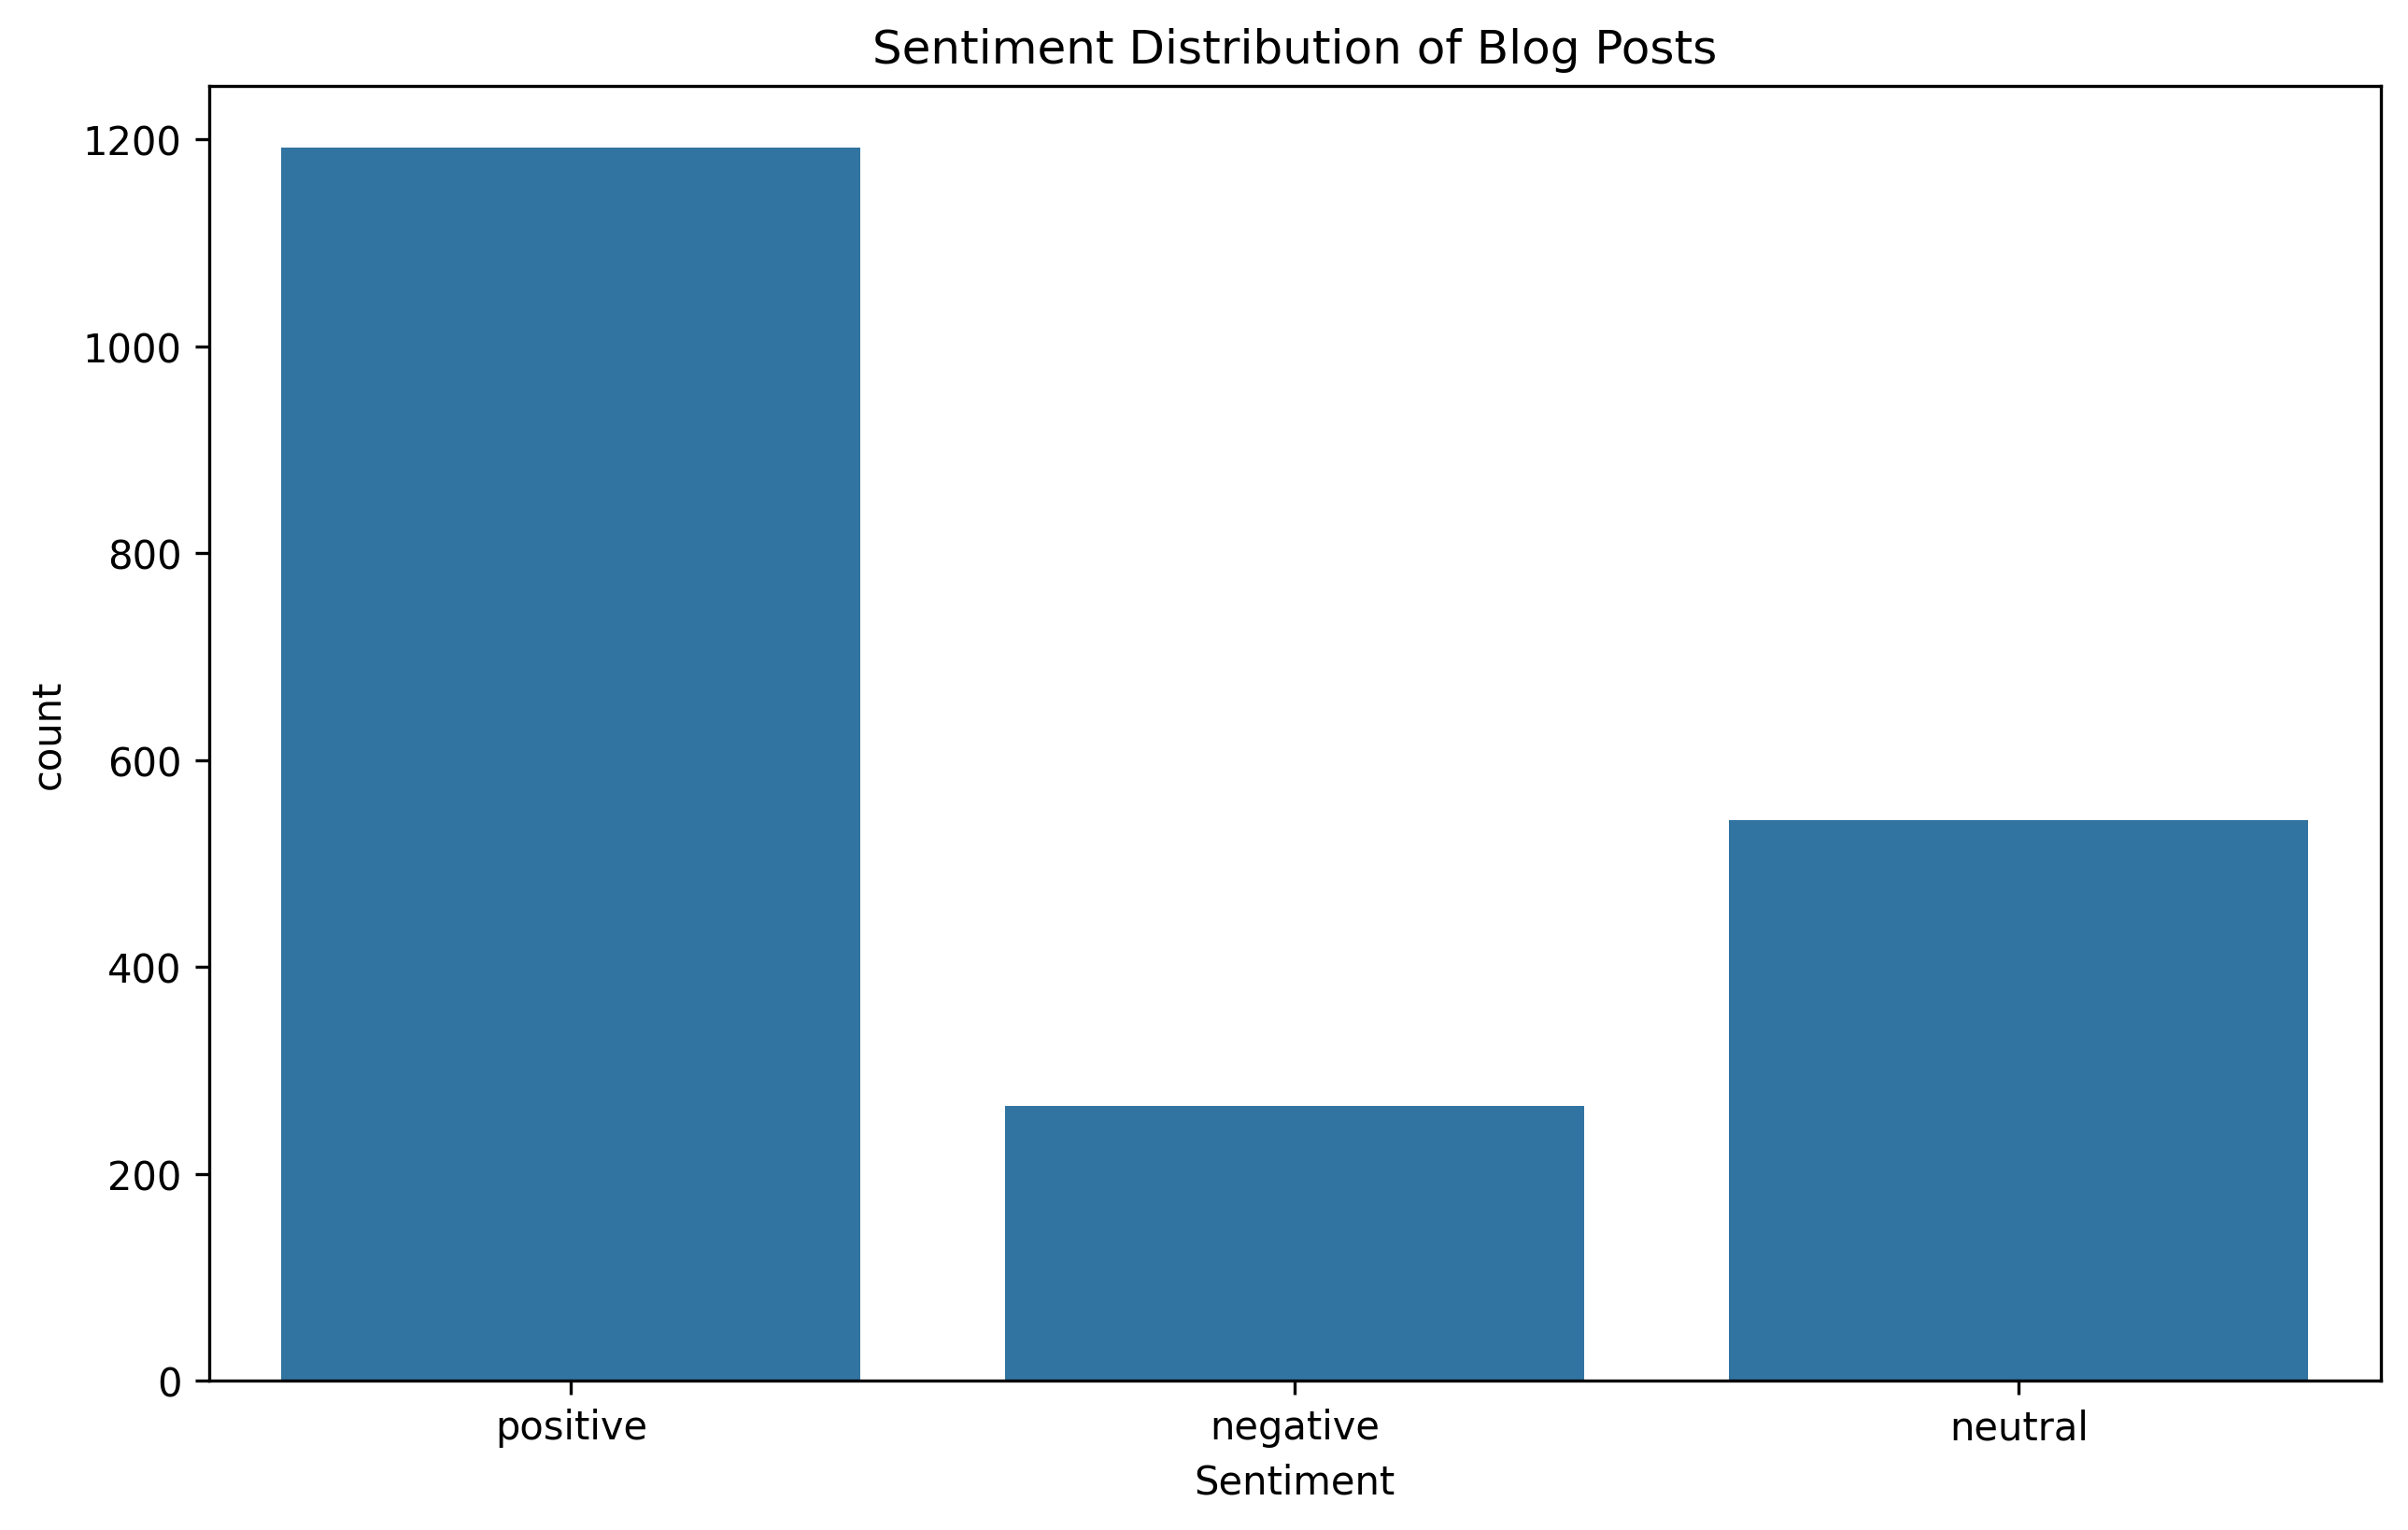

In [25]:
#Sentiment plot
plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiment', data=df)
plt.title('Sentiment Distribution of Blog Posts')
plt.show()

In [26]:
#data with sentiments
df

Data              Labels  \
0     Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...         alt_atheism   
1     Newsgroups: alt.atheism\nPath: cantaloupe.srv....         alt_atheism   
2     Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...         alt_atheism   
3     Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...         alt_atheism   
4     Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...         alt_atheism   
...                                                 ...                 ...   
1995  Xref: cantaloupe.srv.cs.cmu.edu talk.abortion:...  talk_religion_misc   
1996  Xref: cantaloupe.srv.cs.cmu.edu talk.religion....  talk_religion_misc   
1997  Xref: cantaloupe.srv.cs.cmu.edu talk.origins:4...  talk_religion_misc   
1998  Xref: cantaloupe.srv.cs.cmu.edu talk.religion....  talk_religion_misc   
1999  Xref: cantaloupe.srv.cs.cmu.edu sci.skeptic:43...  talk_religion_misc   

      Num_labels Sentiment  
0              1  positive  
1              1  negative  
2              1  positive  
3              1  positive  
4              1  positive  
...          ...       ...  
1995          20   neutral  
1996          20  positive  
1997          20  positive  
1998          20  positive  
1999          20  positive  

[2000 rows x 4 columns]

In [27]:
#sentiments across categories
sentiment_distribution = df.groupby('Labels')['Sentiment'].value_counts(normalize=True).unstack()
print(sentiment_distribution)


Sentiment                 negative  neutral  positive
Labels                                               
alt_atheism                   0.12     0.28      0.60
comp_graphics                 0.15     0.25      0.60
comp_os_ms-windows_misc       0.17     0.19      0.64
comp_sys_ibm_pc_hardware      0.12     0.27      0.61
comp_sys_mac_hardware         0.12     0.24      0.64
comp_windows_x                0.17     0.27      0.56
misc_forsale                  0.13     0.21      0.66
rec_autos                     0.11     0.20      0.69
rec_motorcycles               0.14     0.24      0.62
rec_sport_baseball            0.17     0.27      0.56
rec_sport_hockey              0.20     0.28      0.52
sci_crypt                     0.08     0.32      0.60
sci_electronics               0.07     0.39      0.54
sci_med                       0.19     0.28      0.53
sci_space                     0.13     0.22      0.65
soc_religion_christian        0.09     0.33      0.58
talk_politics_guns          

<Figure size 3600x2400 with 0 Axes>

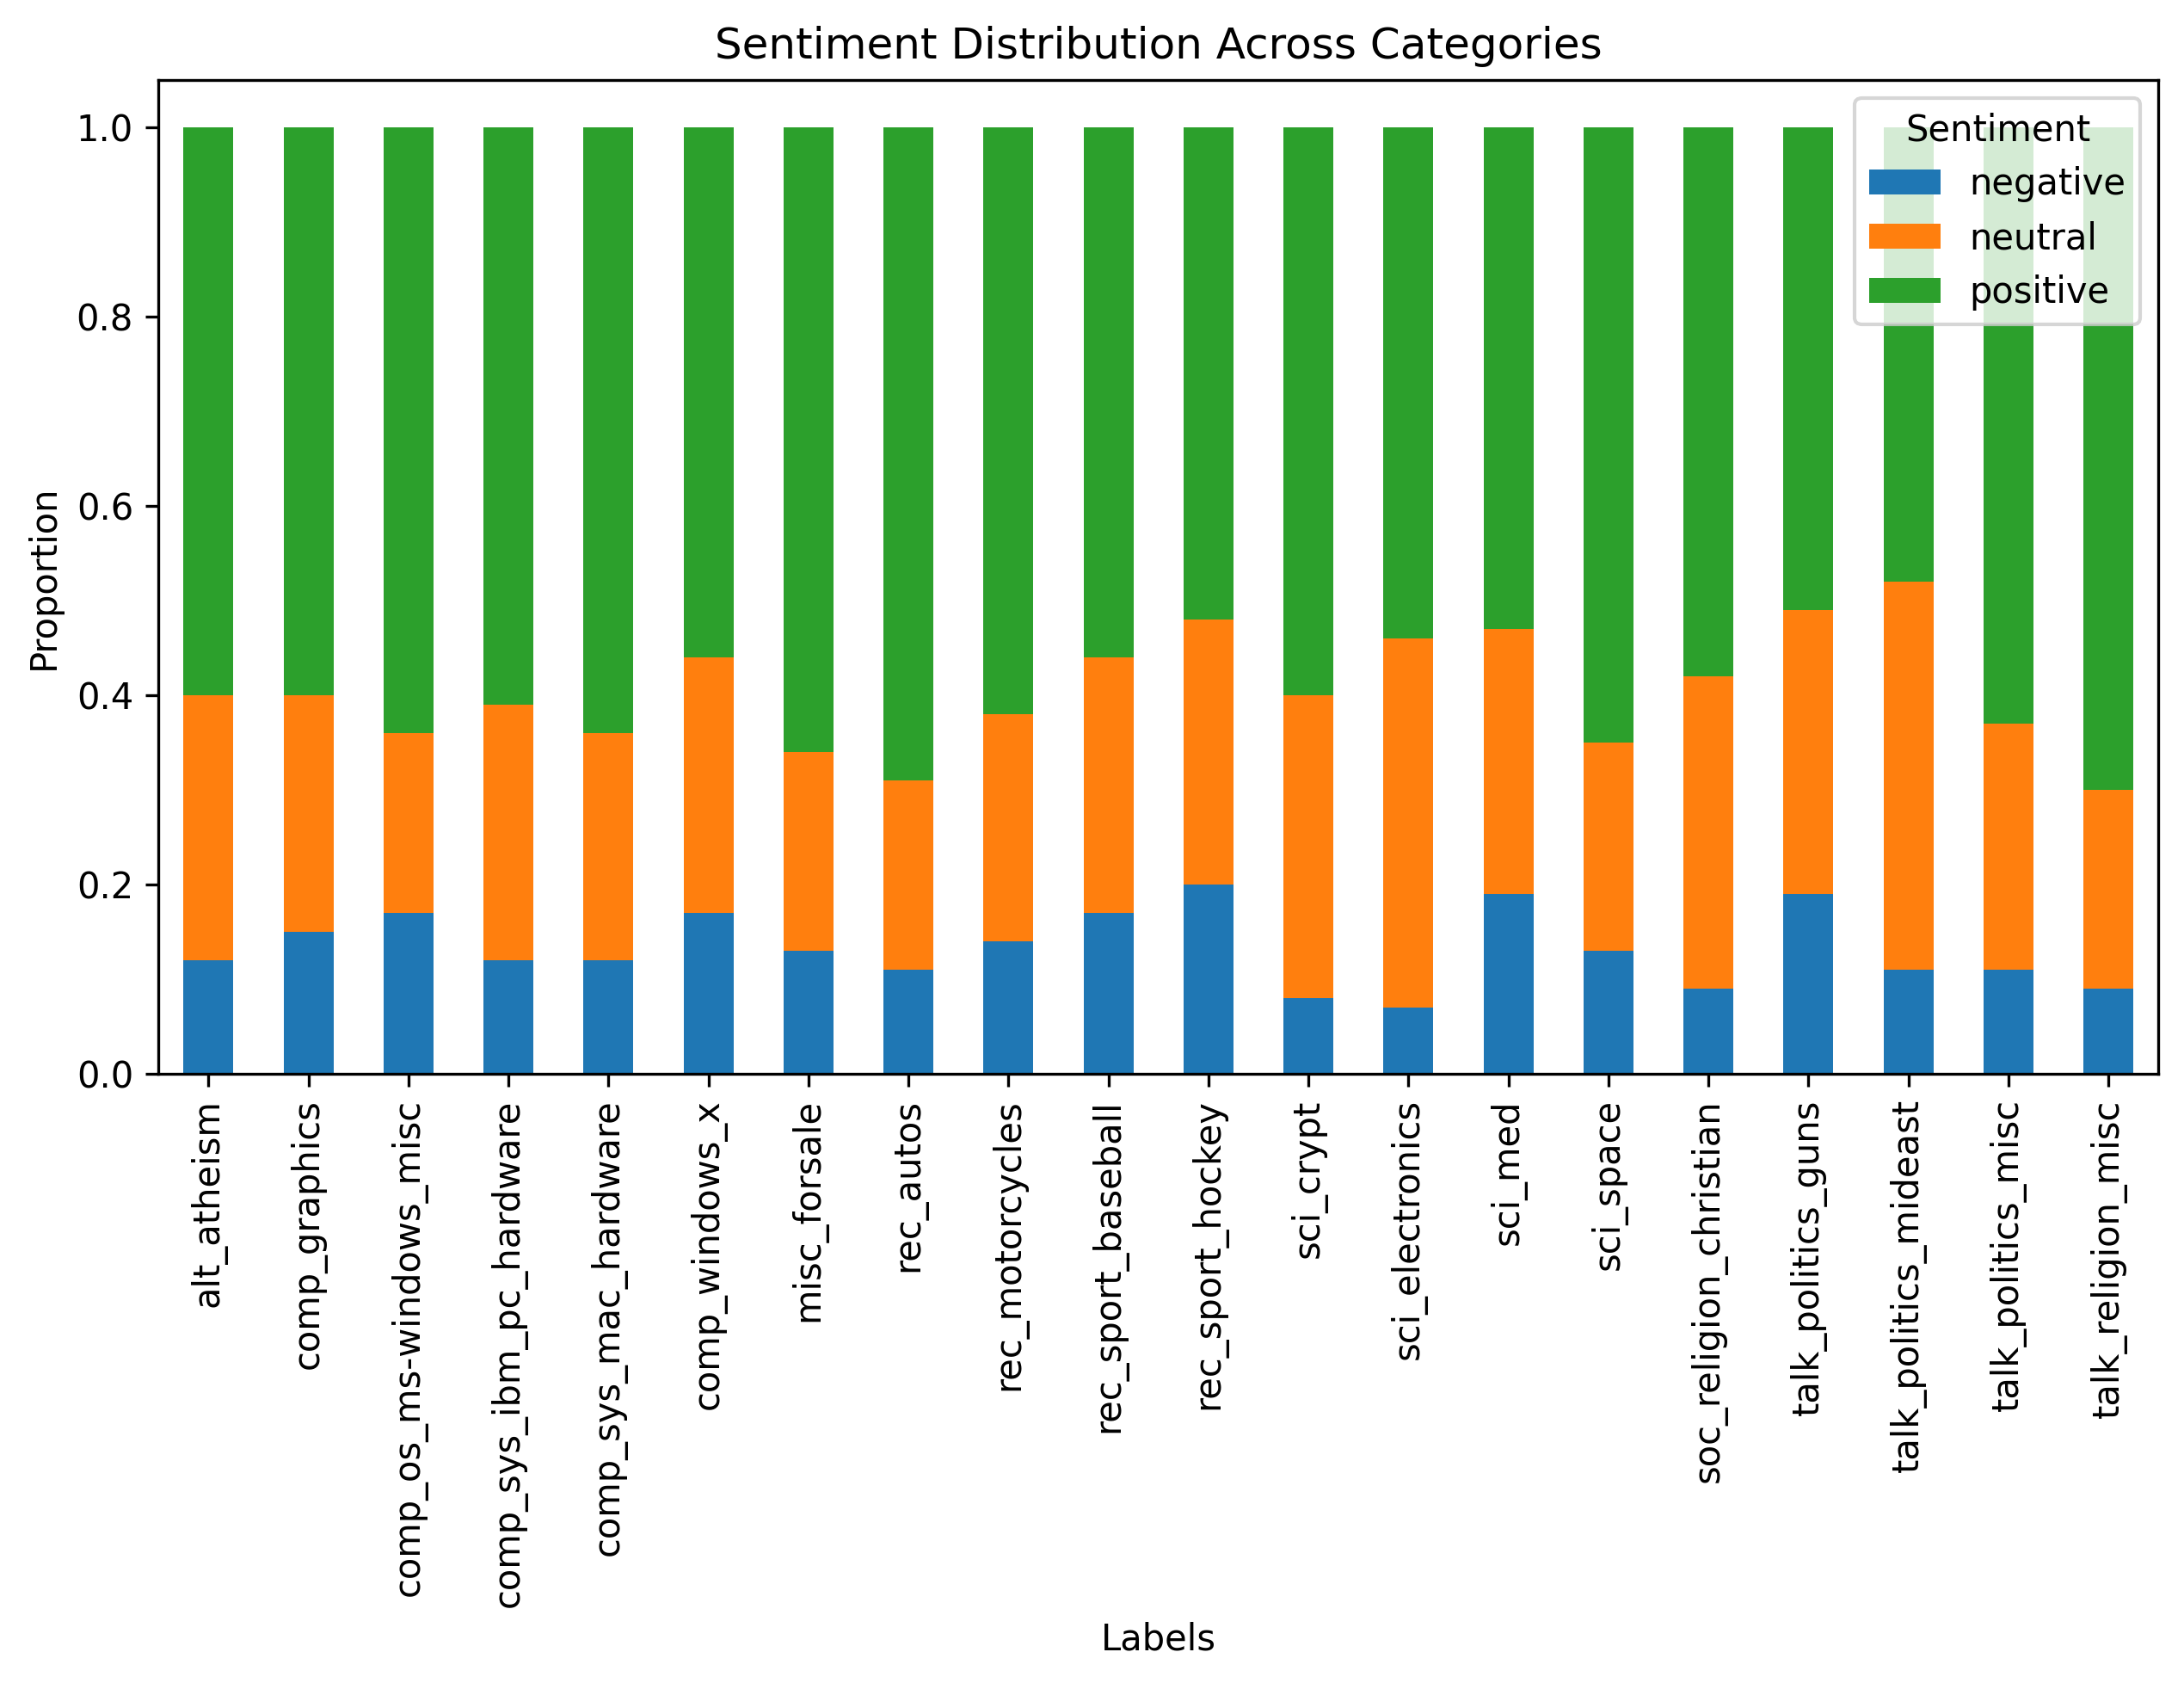

In [28]:
#plot
plt.figure(figsize=(12, 8))
sentiment_distribution.plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution Across Categories')
plt.ylabel('Proportion')
plt.show()

**Sentiments distribution across all the types is more or less uniform**